# VAD

author: steeve LAQUITAINE

date: 04/08/2021


## Abstract

Voice activity detection is critical to reduce the computational cost of continuously monitoring large volume of speech data necessary to swiftly detect command utterances such as wakewords. My objective was to code a Voice Activity Detector (VAD) with reasonable performances (Low false rejection rate) based on a neural network within a week and with low computing resources. The model was trained and tested on labelled data from LibriSpeech prepared by SONOS. I used TensorFlow to develop the model and tested several common VAD modifications such as smoothing, minimum speech time, hangover scheme [TODO]. I relied on a set of diverse development and visualization tools to make sense of the data, clean the data and inspect the inner workings of the model and the pipelines. Future work will integrate additional existing speech and noise datasets (some can be found on http://openslr.org). I strived to go beyond just solving the challenge itself.

## Method

### Performance metrics

I used False rejection rate (FRR) as the key measure of model performance. FRR also called False negative rate or miss rate equates to 1 - Recall and is calculated as:

$$
FRR = \frac{FN}{FN + TP}
$$

where "FN", for false negatives are incorrect rejection of speech and TP, for True positives are correct detections of speech.

My reasoning was that: 

- the main goal is not to miss speech periods to maximize users satisfaction:
- it is widely used in most paper in the field

The disadvantage of greedily maximizing that metrics is that it could train a model that detects everything as speech, generating lots of false positive, a poor user experience. It is also very computationally expensive.

### Dataset

The dataset contains 1914 files separated in 957 .wav audio files associated with a label file (n=957) with the same name.

### Model implementation

#### System description

In [ ]:
# Move to project path
import os
os.chdir(context.project_path)

# import dependencies
import os
import scipy
import glob
import time
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter

# run kedro pipelines
from kedro.io import DataCatalog, MemoryDataSet
from kedro.runner import SequentialRunner
from vad.pipelines.data_eng import pipeline as data_eng
from vad.pipelines.inference import pipeline as inference
from vad.pipelines.evaluate import pipeline as evaluate
from kedro.pipeline import Pipeline
import mlflow
from kedro.extras.datasets.tensorflow import TensorFlowModelDataset

# ignore warnings for esthetics
import warnings
warnings.filterwarnings('ignore')
# parameters
VERBOSE = True

##### Training pipeline:

we display below the directed acyclic graph of our training pipeline, plotted with the `kedro-viz` api.

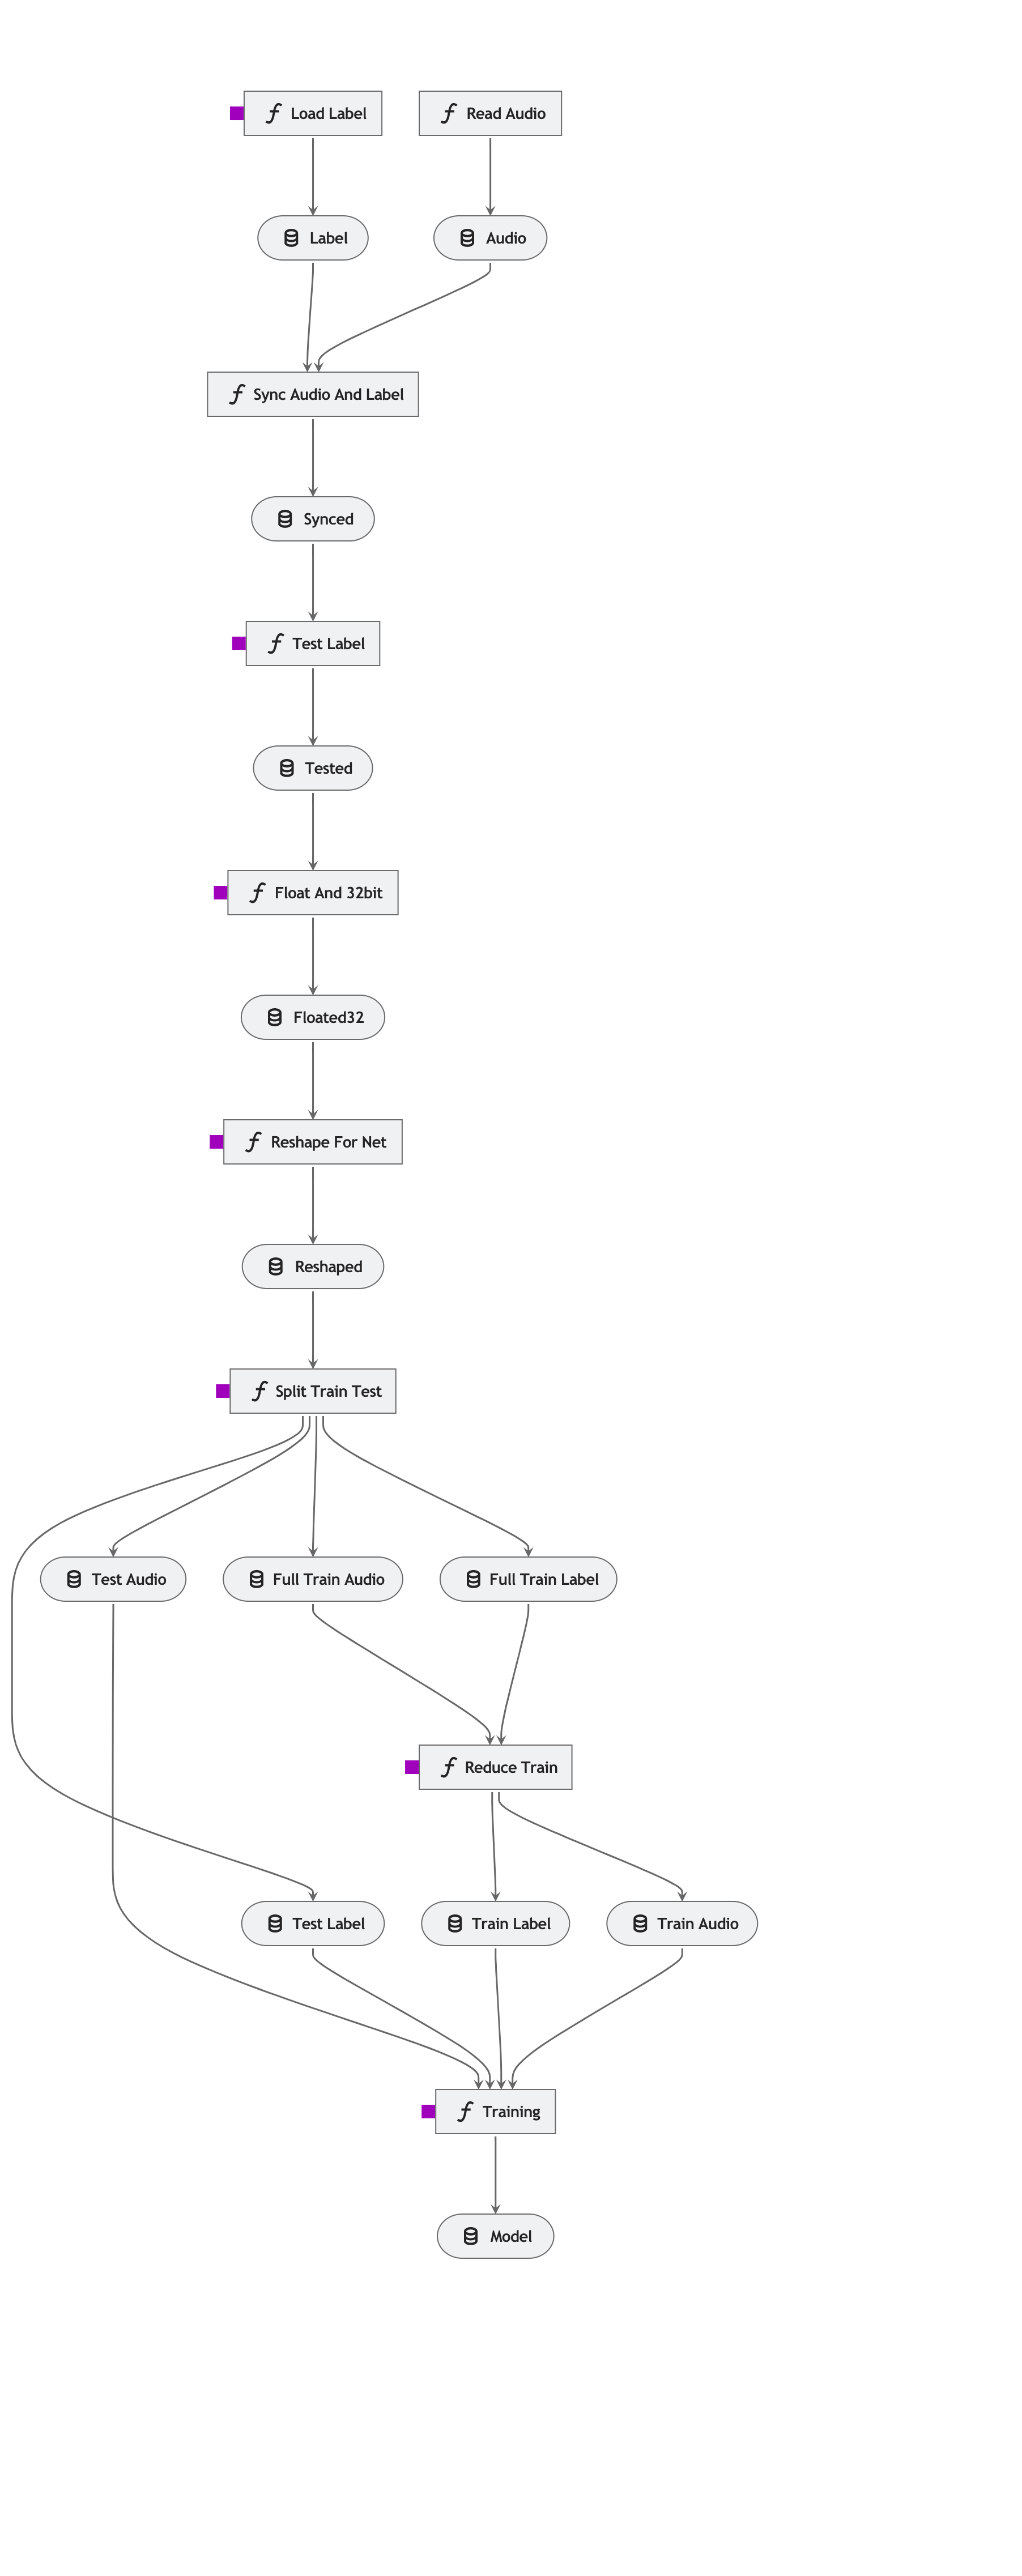

In [115]:
# load tensorboard conceptual graph
from IPython.display import Image
Image(filename='notebooks/assets/kedro_train_pipeline.png', width=100, height=100) 

##### Inference pipeline:

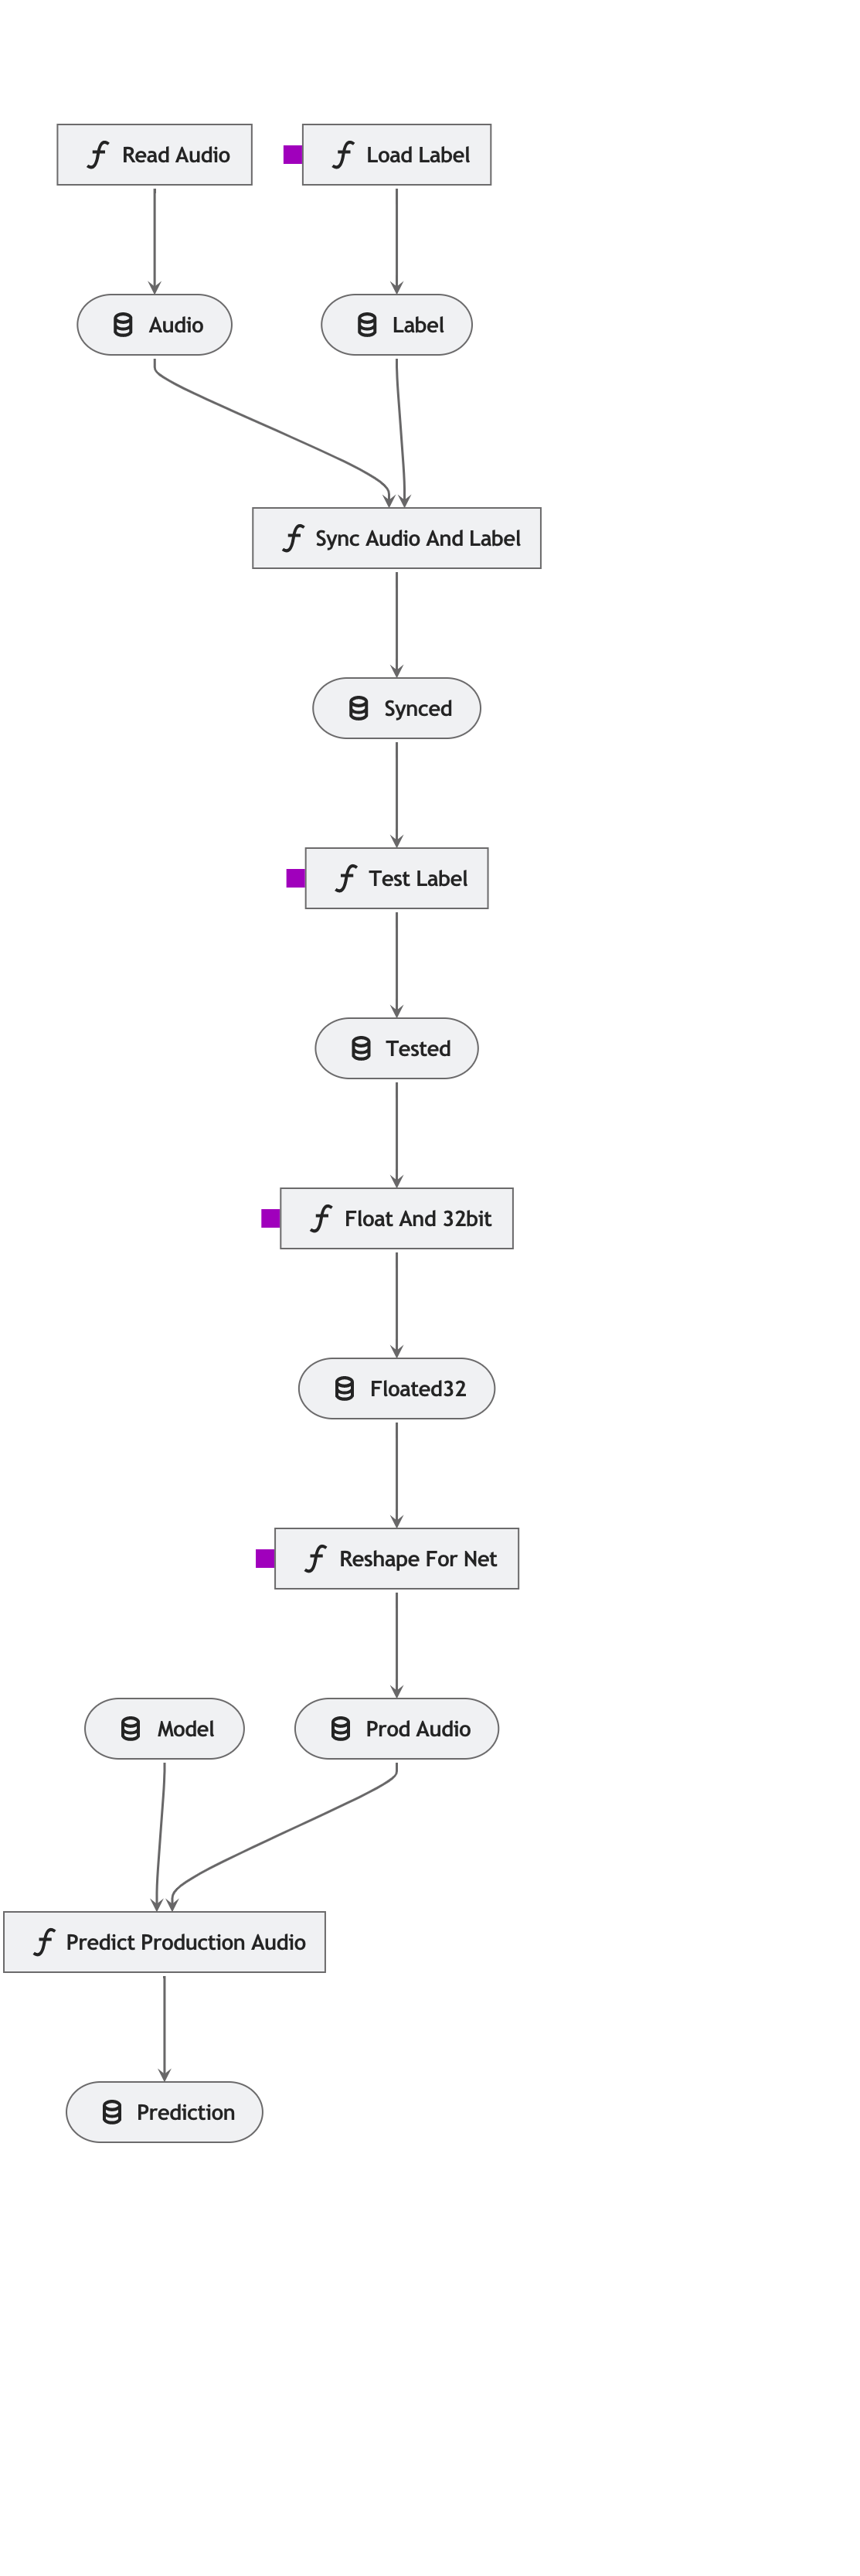

In [116]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/kedro_inference_pipeline.png', width=100, height=100) 

##### Evaluation pipeline

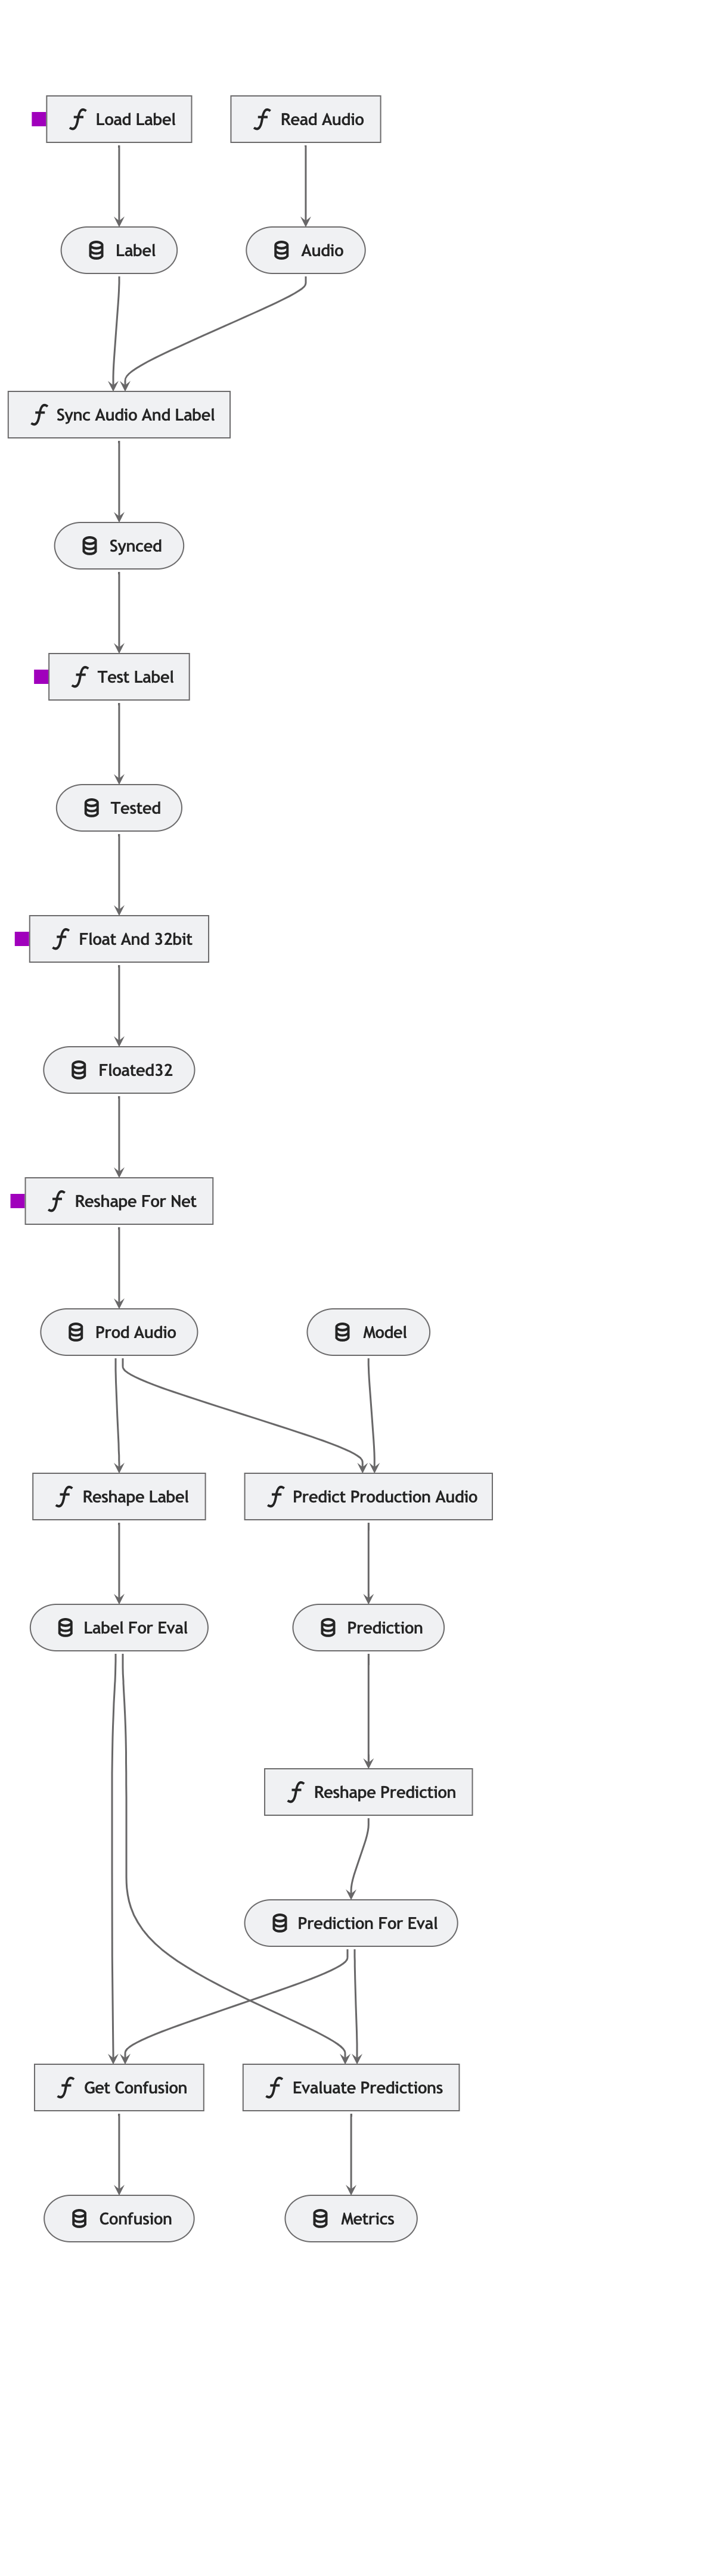

In [117]:
# load tensorboard conceptual graph
from IPython.display import Image
Image(filename='notebooks/assets/kedro_eval_pipeline.png', width=100, height=100)

we display below our inference pipeline.

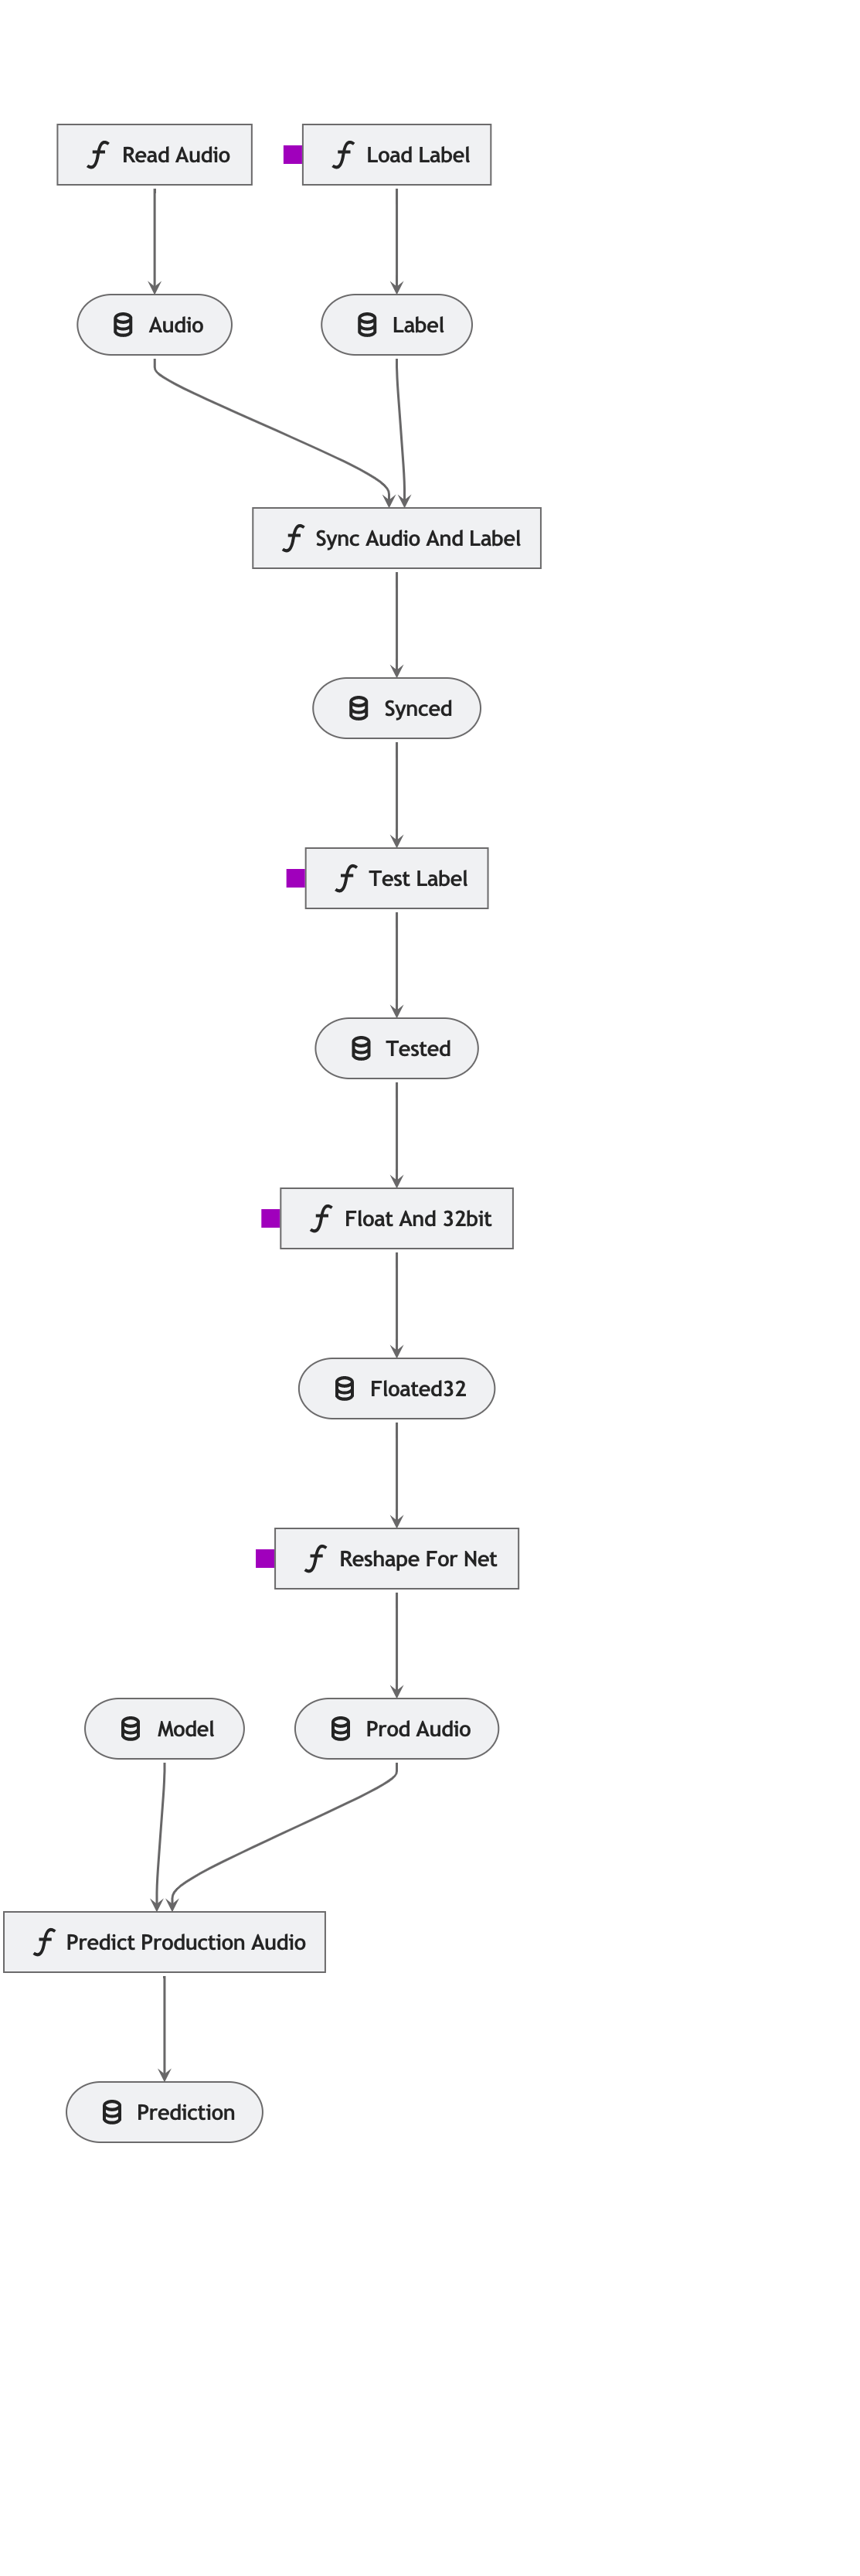

In [118]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/kedro_inference_pipeline.png') 

#### Neural network architecture:

Due to poor computational power, I develop on a laptop, I chose to test minimal network architectures containing up to two hidden layers and a dense binary classification layer. I show the single GRU layer's network's conceptual graph generated by the tensorboard api below.

After cloning the project's repository, the graph can be loaded in your web browser by running the command below in a linux (or MacOS unix) terminal: 

```bash
cd ../vad
tensorboard --logdir tbruns
```

where ../vad is the clone repository directory.

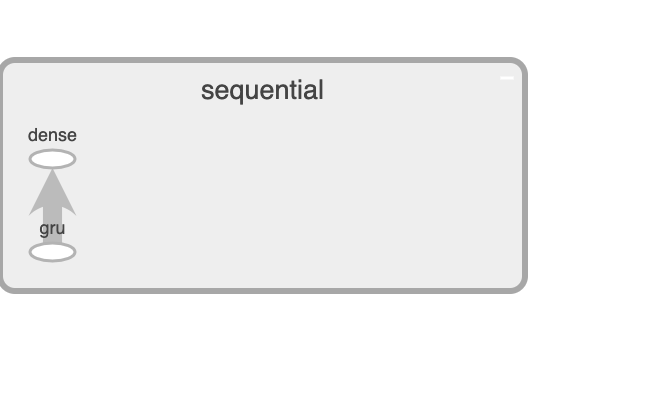

In [119]:
# load tensorboard conceptual graph
from IPython.display import Image
Image(filename='notebooks/assets/tb_conceptual_graph.png') 

I show below a more detailed description of the network layers generated with tensorflow keras' plot_model() api.

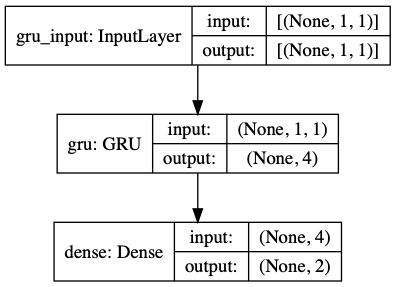

In [120]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/keras_model_architecture.png') 

I show below the model's number of trainable and non-trainable parameters:

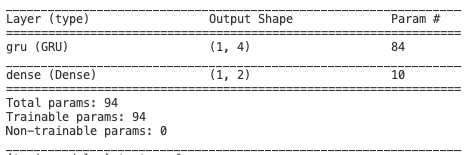

In [121]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/summary_params.png') 

## Experimental approach

I chose to implement the simplest modeling approach in order to ensure quick iterations and debugging. My approach was based on sequential hypothesis testing.


### Can I get above chance False rejection rate with a minimal modeling pipeline ?

I first extracted a small sample of the real data to get fast training at the expense of performance. I trained a simple 1-layer GRU model which takes as input a single batch with one look-back timestep and projects to a fully connected binary classification layer with a softmax activation function. I first trained the model with one epoch. I used `Adam`, an adaptive optimizer that is well known to handle the complex training dynamics of recurrent networks better than simple gradient descent optimization. Training the model on a 2.8 secs audio from one speaker (20% of the full audio chunk) took 50 secs.

**Results:** [TODO]

### Is more layer better than less ?

I expected that a 2-layer network would perform better than a 2-layer network but both models produced nearly the same false rejection rate and a 2-layer GRU could be train as fast as a single layer.

### Lower resolution better speed?


I tested two data encoding resolutions: float16 and float32 bits. Both resolution took the same time to train.

### Does learning from more timesteps reduce performance ?

I tested 1, 2, 10 and 320 timesteps which correspond to 0.06 ms, 0.12 ms, 1.2 ms and 20 ms with the current sampling rate of 16 Khz.
- Moving from 1 (50 sec training) to 2 timesteps (2 min trainin) produced a 2.5 fold improvement in FRR from 1 timestep (0.34 on average to 0.14) over subjects
- FRR improved by 20% from 2 to 10 timesteps which took 5 min to train.
- Training on 1 timesteps took about 50 secs, on 10 timesteps 90 secs.
- 320 timesteps took too long to train within the given time constrains and was stopped.

### Performance vs. train-test split ?

Performance drastically increased from 0 all over to 0.8-ish train from a 0.5 split to a 0.7. Performance was same for 1 or 2 GRU.

### How long to convergence ?

The loss curve suggests that 7 epoches are enough for convergence (shoulder of the curve).
  

### The more data the better ?


* Training on 20% vs 100% of train set for 7 epochs
  * same results across nb GRU
  * metrics:
    * 100% has:   
      * 15% better recall (86%)
      * 10% lower precision (85%)
      * 4% better f1 (86%)
  

### Does training on 2 secs audio perform well ?


I trained the model on one 2.8 secs from one speaker's audio (19-198-0003.wav) and tested how well the model generalizes to his other audio chunks and other speakers' audios:

- I trained on speaker 0 (19-198) and predicted on a sample of other test audio chunks from the same speaker. The test performance were about 0.85 f1-score.

I tested how well the model prediction generalize to other speakers audio:

- I trained on speaker 0 (19-198) and predicted on two other persons' audio chunks (103-1240-0001, 118-47824-0000). As a result: 

    - 103-1240-0001: 
      - I observed an increase in false rejection rate (50% only compared to ~30%)
      - candidate explanation: other person could speak with lower average amplitudeshorter speech periods which would lead the model to miss speeches
      
    - 118-47824-0000:
      - False rejection rate was the same 

- Synthetic vs. person
    - train on person 1 - predict on synthetic (1263-141777-0000)
        - result: FRR was good

- Loud vs. low voice
    - train on person 1 - predict on human (1447-130551-0019)
        - kept good f1 score 0.7 with good recall and reasonable precision (0.6)

- normal vs. high pace
    - I train on speaker 1 - predict on human (1578-6379-0017)
    - kept good f1 score with good recall and reasonable precision

### Which activation sigmoid (default) vs. biased Softmax

False rejection rate was slightly lower (from 13% to 9% on other subjects test audios) for biased softmax at the dense layer than for the default sigmoid activation function. So I retained Bias softmax.
The speed of convergence remained unchanged.

### Is Inference fast enough ?

Inference took 12.6 sec on a 15 sec audio that is 840 ms / sec.

### Conclusion on best setup

Training dataset:

- 2.8 secs audio from one speaker: this small chunk took 4 min to train while using a full 15 secs audio file (i.e., 5 times more data) took 20 min for a 10% performance improvement.

Architecture:

- 1-layer GRU: Occam's razor principle favors simplicity given the same performance
- Softmax with initial bias to couterbalance the label bias  

Training:

- 1 batch 
- 10 timesteps    
- at least 7 epochs 
- split_frac: 0.7 : had the biggest effect on performance (0 at 0.5 to 0.7 at 0.7)

#### A couple of sanity checks

- Sanity checks:
    - inference pipeline sanity tests:
      - shuffle audio - label mapping
        - result: recall drops at 0.6 (possibly statistcally at chance level), precision 100 (as expected, f1 high because of precision)
      - dummy model that always predicts speech
        - result: recall drops to 0.6 (f1 score stays high because of high precision for speech)
      - dummy model that always predicts no speech
        - result: recall drops to 0 and all others too except 0.39 accuracy
- train pipeline sanity tests:
- train with shuffled labels
  - As expected:        
    - best metrics on test are all 0 except accuracy ay 0.18
    - virtually no reduction in loss
  - same time to train

## Results

### Several speakers

Listening to a sample of the audio files revealed that a variety of speakers

- Humans
    - men
    - women
- Synthetic
    - men
    - women

I also characterised speeches by their variety of amplitudes and pace
- Normal vs fast pace  
- Loud vs, low volume

### Speech signal description

We show below the best typical example of an audio signal (top panel). and its associated speech labels "1" for speech and "0" for no speech (bottom panel).

All audio signals were 32 bits float single channel time series. We run a few sanity checks:

In [122]:
# load all data
data_path = "data/01_raw/vad_data/"
audio_files = glob.glob(f"{data_path}*.wav")
audio_files.sort()
label_files = glob.glob(f"{data_path}*.json")
label_files.sort()

In [123]:
# run sanity test on file-label name mapping and sorting
correct_mapping = []
for aud, lbl  in zip(audio_files, label_files):
    correct_mapping.append(os.path.splitext(aud)[0] == os.path.splitext(lbl)[0])
print(f"- the {sum(correct_mapping)} label files were correctly mapped with the {len(audio_files)} audio files")

- the 957 label files were correctly mapped with the 957 audio files


Speaker information:

In [124]:
# get speaker info
file_speaker = [os.path.basename(file).split("-")[0] for file in audio_files]
speaker_set = np.unique(file_speaker)
print("- Number:", len(speaker_set), "speakers")
print("- Speakers'ID:", speaker_set)

- Number: 34 speakers
- Speakers'ID: ['103' '1034' '1040' '1069' '1081' '1088' '1098' '1116' '118' '1183'
 '1235' '1246' '125' '1263' '1334' '1355' '1363' '1447' '1455' '150'
 '1502' '1553' '1578' '1594' '1624' '163' '1723' '1737' '1743' '1841'
 '1867' '1898' '19' '1926']


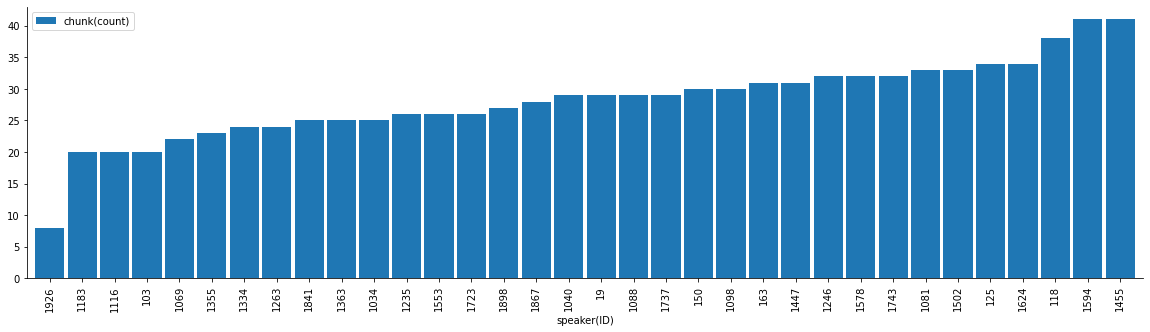

In [149]:
# get number of chunks per speaker
speaker, nb_chunks = zip(*Counter(file_speaker).items())
counts = pd.DataFrame(data=(speaker, nb_chunks), index=["speaker(ID)", "chunk(count)"]).T
counts.sort_values(by="chunk(count)").plot.bar(x="speaker(ID)", figsize=(20, 5), width=0.9);
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

In [126]:
# define a few useful functions
def read_X(audio_path):
    sample_rate, data = scipy.io.wavfile.read(
        audio_path
    )
    sample_size = len(data)
    time_unit = 1 / sample_rate
    duration_in_sec = time_unit * len(data)
    timestamp = np.arange(0, len(data), 1) * time_unit
    return {
        "audio": {
            "data": data.reshape(sample_size, 1),
            "metadata": {
                "sample_rate": sample_rate,
                "sample_size": sample_size,
                "time_unit": time_unit,
                "duration_in_sec": duration_in_sec,
                "timestamp": timestamp,
            },
        }
    }
    
def load_Y(label_path):
    return pd.read_json(label_path)    

def sync_audio_and_labels(audio, label):

    # get data
    data = audio["audio"]["data"]
    time_unit = audio["audio"]["metadata"]["time_unit"]
    sample_size = audio["audio"]["metadata"]["sample_size"]

    # create timestamps
    audio["audio"]["metadata"]["timestamp"] = np.arange(0, len(data), 1) * time_unit

    # case label exists
    # synchronize labels with audio
    synced_label = np.zeros((sample_size, 1))
    array = label.values
    for ix in range(array.shape[0]):
        interval = array[ix][0]
        speech_start = interval["start_time"]
        speech_end = interval["end_time"]
        span = np.where(
            np.logical_and(
                audio["audio"]["metadata"]["timestamp"] >= speech_start,
                audio["audio"]["metadata"]["timestamp"] <= speech_end,
            )
        )
        synced_label[span] = 1
    audio["label"] = synced_label
    return audio

def load_synced_audio_and_label(audio_path, label_path):
    audio = read_X(audio_path)
    label = load_Y(label_path)
    return sync_audio_and_labels(audio, label)
    
def plot_labelled_audio(timestamp, audio, labels, n_sample):
    # plot audio
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,5))
    ax1.plot(timestamp, audio[:n_sample], "r-")

    # plot label
    ax2.plot(timestamp, labels[:n_sample], "b-")
    ax2.set_ylim([-0.1, 1.1])
    plt.show()
    
    return f, ax1, ax2

We show below a few interesting example chunks for 7 different speakers (numbered panels).
- All visualized audio were very well labelled (see supplementary).
- Background noise is very low and stationary.


SPEAKER 19 - PANEL 0
  data/01_raw/vad_data/19-198-0003.wav
  data/01_raw/vad_data/19-198-0003.json


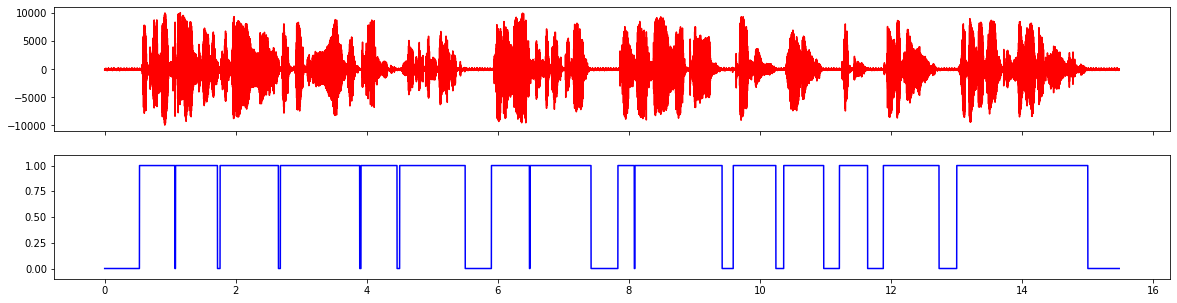

SPEAKER 1553 - PANEL 1
  data/01_raw/vad_data/1553-140048-0009.wav
  data/01_raw/vad_data/1553-140048-0009.json


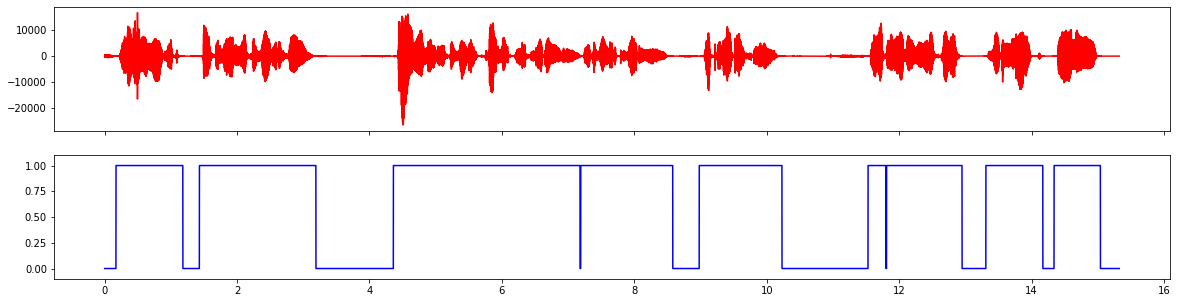

SPEAKER 103 - PANEL 2
  data/01_raw/vad_data/103-1241-0027.wav
  data/01_raw/vad_data/103-1241-0027.json


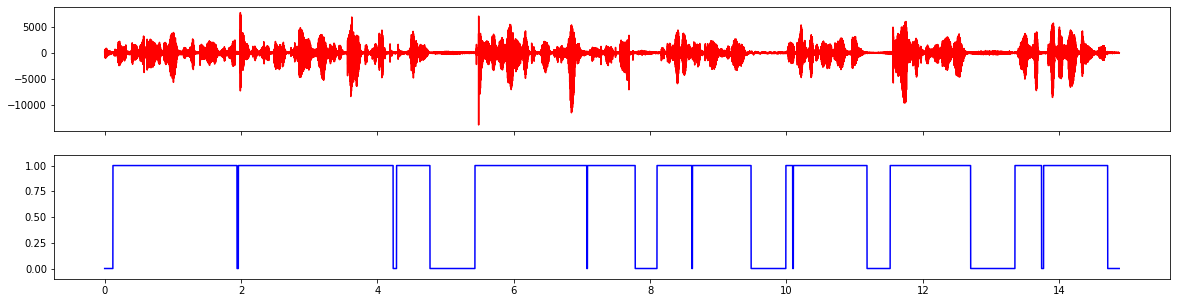

1.95 sec


In [127]:
# show an example per speaker
exple_pos = [920, 605, 17]

# sync audio and labels
tic = time.time()
for ix, exple in enumerate(exple_pos):
    print(f"SPEAKER {file_speaker[exple]} - PANEL {ix}")
    print(" " , audio_files[exple])
    print(" " , label_files[exple])    
    audio = load_synced_audio_and_label(audio_files[exple], label_files[exple])
    f, ax1, ax2 = plot_labelled_audio(
        audio["audio"]["metadata"]["timestamp"], 
        audio["audio"]["data"], 
        audio["label"], 
        n_sample=len(audio["label"]), 
    )
if VERBOSE: 
    print(np.round(time.time()-tic,2), "sec")

We validated that all audio files were associated with a .json label file.


In [128]:
# data quality check
print("- audio file sample size:", len(audio_files))
print("- label file sample size:", len(label_files))

- audio file sample size: 957
- label file sample size: 957


The entire sample could be loaded quickly:

In [129]:
# loading
tic = time.time()
audio_data = [scipy.io.wavfile.read(audio) for audio in audio_files]
print("- loading duration:", np.round(time.time()-tic,2), "sec")

- loading duration: 5.36 sec


Sample size and sampling rate:

In [130]:
# get sample rate per audio
sample_rates = [audio for audio in np.array(audio_data)[:,0]]
sample_rate = np.unique(sample_rates)
print("Sample rate information:")
print("-", len(sample_rate), "sample rate(s)")
print("- rate:", np.unique(sample_rates)[0], "Hz")

Sample rate information:
- 1 sample rate(s)
- rate: 16000 Hz


We kept the signal at 16Khz which is enough to cover the frequency range of human speech according to the literature (Human voice b/w `85hz to 8khz` [REF], hearing b/w `20 hz to 20kh`[REF]).

In [131]:
# get sample size per audio
sample_sizes = [len(audio) for audio in np.array(audio_data)[:,1]]
print("Sample size information:")
print("-", len(np.unique(sample_sizes)), "sample size(s)")
print("- max:", max(sample_sizes), "samples (", max(sample_sizes)/sample_rate, "secs)")
print("- min:", min(sample_sizes), "samples (", min(sample_sizes)/sample_rate, "secs)")
print("- median:", np.median(sample_sizes), "samples (", np.median(sample_sizes)/sample_rate, "secs)")

Sample size information:
- 711 sample size(s)
- max: 275280 samples ( [17.205] secs)
- min: 22560 samples ( [1.41] secs)
- median: 222080.0 samples ( [13.88] secs)


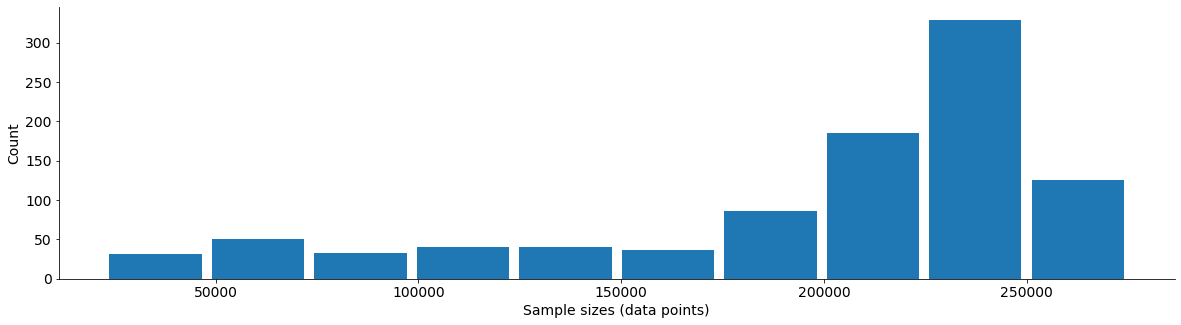

In [132]:
# sample size distribution
fig = plt.figure(figsize=(20,5))
plt.hist(sample_sizes, rwidth=0.9);
plt.xlabel("Sample sizes (data points)", fontsize=14);
plt.ylabel("Count", fontsize=14);
plt.xticks(fontsize=14); 
plt.yticks(fontsize=14);
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

**Signal amplitudes**: the true decibel amplitude of the audio will depend on each speaker's microphone characteristics, the speaker's distance to its microphone, the speaker's volume configuration. Having no acces to these information we did not derive the true decibel amplitude (dB) from the raw audio signal amplitude or compared absolute amplitudes between speakers. Rather we compared the signals' signal-to-noise ratio (SNR).

### Speech signals are nearly pure

[TODO]: calculate the distribution of SNRs.
1. Estimate noise in frequency domain and decompose audio signal into signal and noise components.
2. Calculate the root-mean square level of the noise without speech and the speech without noise
3. Use to calculate SNR

In [133]:
# define some useful functions
def get_signal(audio_path, label_path):
    pass
def get_noice(audio_path, label_path):
    pass
def get_snr(audio_path, label_path):
    synced = load_synced_audio_and_label(audio_path, label_path)
    audio = synced["audio"]["data"]
    label = synced["label"]
    S_rms = audio[label==1]
    N_rms = label[label==0]
    return 20*np.log10(S_rms / N_rms)

In [134]:
# get snr
# get_snr(audio_files[0], label_files[0])

### Speech and no-speech classes are imbalanced in the training dataset

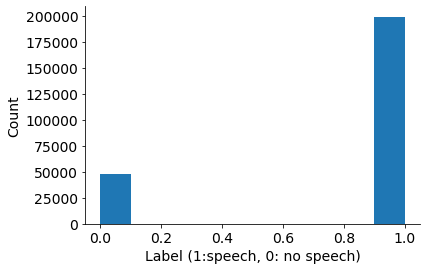

In [183]:
train_audio_path = "data/01_raw/vad_data/19-198-0003.wav"
train_label_path = "data/01_raw/vad_data/19-198-0003.json"
data = load_synced_audio_and_label(train_audio_path, train_label_path)
plt.hist(data["label"]);
plt.xlabel("Label (1:speech, 0: no speech)", fontsize=14);
plt.ylabel("Count", fontsize=14);
plt.xticks(fontsize=14); 
plt.yticks(fontsize=14);
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

In [ ]:
ax = pd.DataFrame(data["label"]).plot.barh(stacked=True)


### The 1-layer GRU net converges within 7 epochs

I monitored training quality in Tensorboard api. I display below the loss curve calculated for 7 training epochs (x-axes ranging from 0 to 6) on training dataset (dark curve) and validation dataset (blue curve). The model was trained with 10 timesteps look-back (see logged runs in tensorboard for vad-1-gru-20210901-131436/train/train, vad-1-gru-20210901-131436/train/validation in tensorboard web api). Categorical cross-entropy on training data was not flat as expected from a model that doesn't learn but goes down until convergence near the 7th epoch.

I also monitored recall to evaluate improvement in recall (decrease in FRR) over training. Recall increased (thus FRR decreased) by 10% within 7 epochs and took about 4 epochs to converge on the training dataset. Recall on validation was already high since the first epoch and remained stable over training (see logged runs in tensorboard for vad-1-gru-20210901-131436/train/train, vad-1-gru-20210901-131436/train/validation).

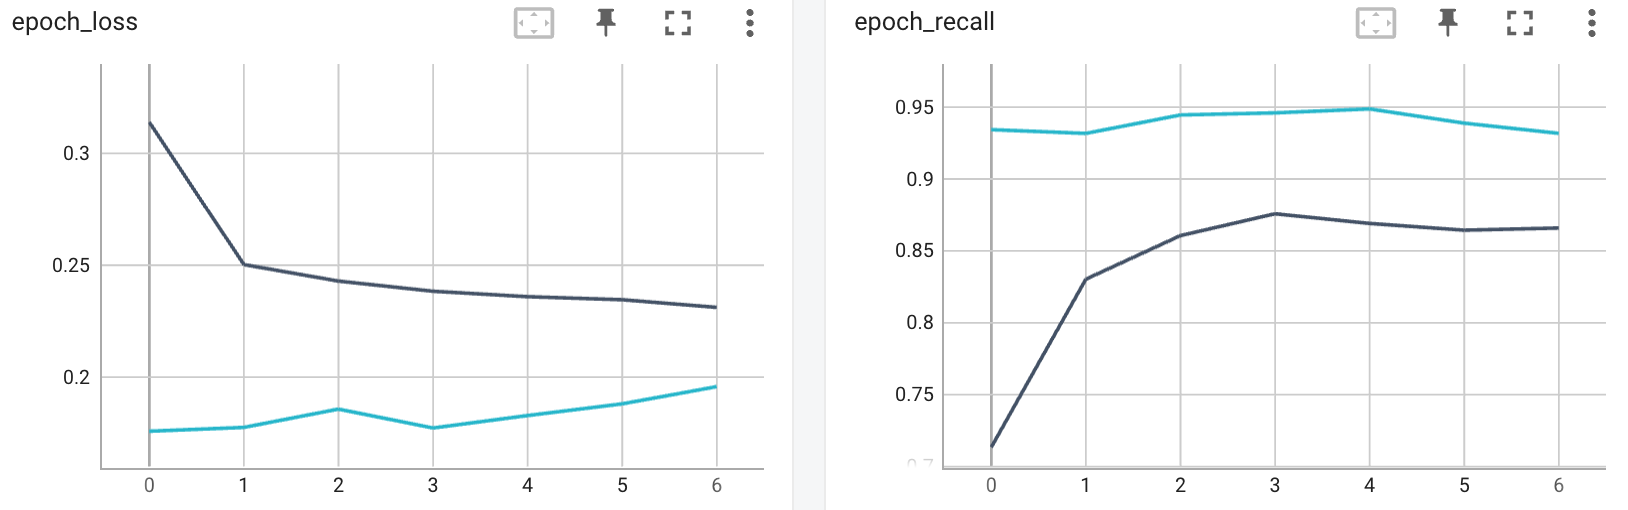

In [150]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/loss_recall_per_epoch.png') 

### Weights and biases follow well-behaved multimodal distributions 

Both the Gru and dense layer show distribution that did not get stuck at 0 values and did not display large outlier values. This suggests that our GRU units successfully circumvented the vanishing gradient problem that is typical of more traditional RNN.

**Gru layer**

The GRU l layer has 3 types of trainable parameters:
- weights ("kernel_0")
- recurrent weights ("kernel_0")
- biases ("kernel_0")

I will refer to iterations as epochs as for a single batch, iterations equal the number of epochs.

- Weight and bias values 
    - The weight distribution was very sparse with the majority of weights being null and some values being spread at negative and positive values.
    - GRU layer's biases and recurrent weights slightly changed over epochs (y-axis), spreading across a larger range of values.

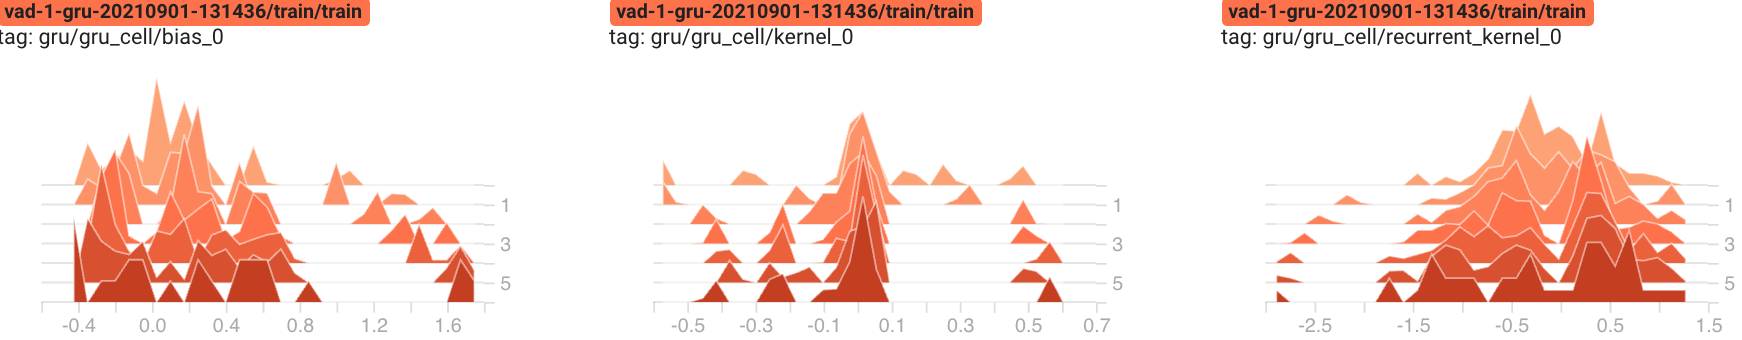

In [137]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/tb_gru_weights_hist_per_iter.png') 

These changes in the bias and weights distributions are more apparent on the plot of the weight values against epochs (different shading columns represent the distributions' 90th, 60th percentiles ...)
(x-axis).

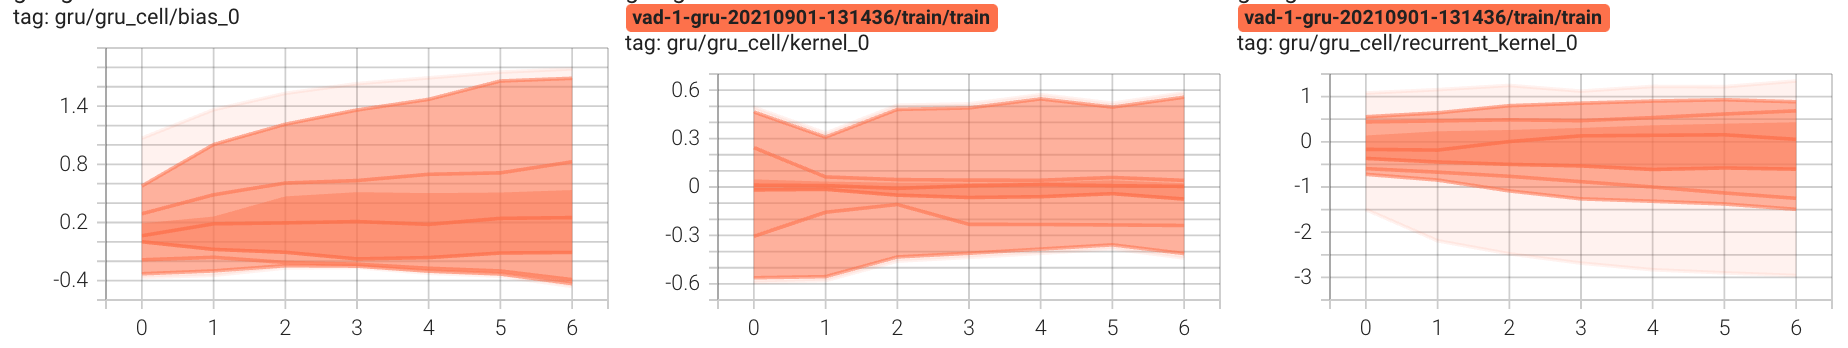

In [148]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/tb_gru_weights_hist_per_epoch.png') 

**Dense layer**

- Dense layer's weights and biases did not get not stuck at 0 and did not display large outlier values.
    - Biases followed a bi-modal distributions with some weights at -1, others peaking at -0.3 and other at +0.3. There are no outlier biases.
    - Weights followed a tri-modal distributions with some weights at -1, a small majority peaking at 0 and some peaking at +1.5. There were no outlier bias values.

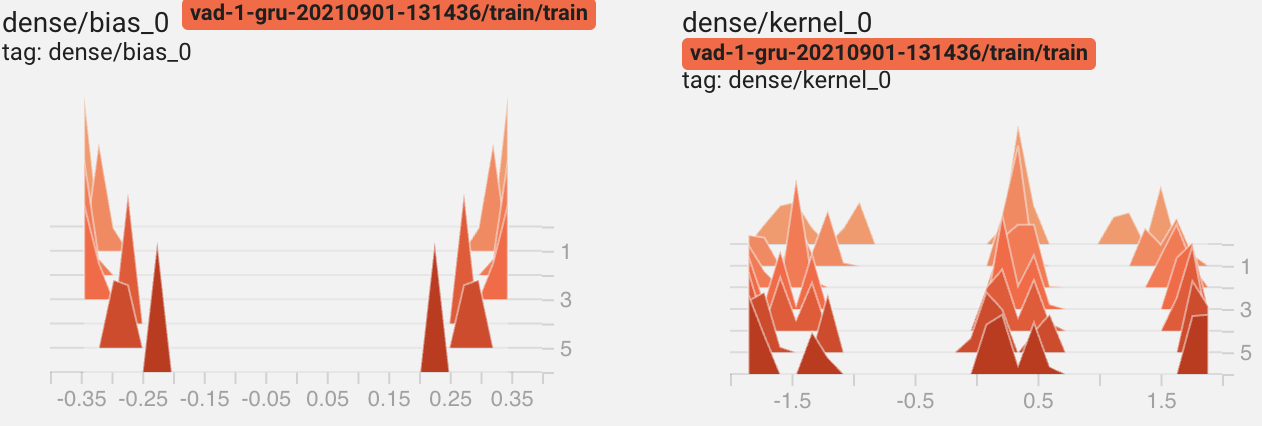

In [139]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/tb_dense_hist_per_iter.png') 

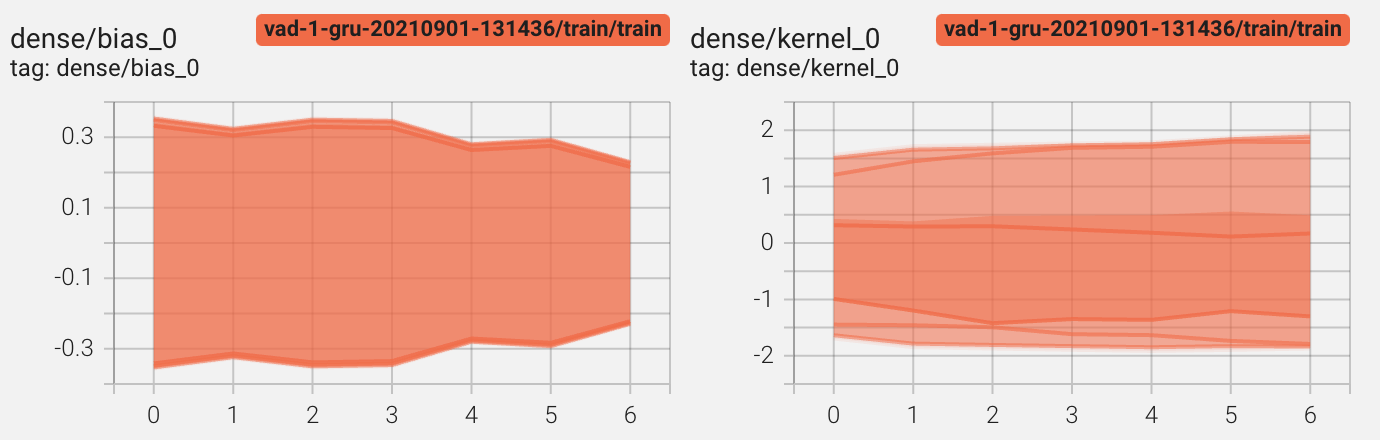

In [140]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/tb_dense_hist_per_epoch.png') 

### A simple RNN predicts well

**Experiment 1**

I first trained the model on a small chunk (2.8 secs) of one speaker data and I tested it on one full audio for each of the 34 speakers' (about 3.5 min, for 15 sec inference per audio file). I chose the first audio for simplicity. Further analyses must assess whether the first audio is representative of the other audios for each speaker. I chose a sample and not the entire dataset because inference would take more than 3 hours on the 957 files. I show below the distribution of the best model's False rejection rates over the sample test dataset. 

In [141]:
# define data engineering pipeline
from kedro.pipeline import Pipeline, node
from vad.pipelines.data_eng.nodes import Etl, DataEng

def run_data_eng(**kwargs):
    return Pipeline(
        [
            node(
                func=Etl.test_on_label,
                inputs=["synced", "params:TEST"],
                outputs="tested",
                name="test_label",
            ),
            node(
                func=DataEng.set_resolution,
                inputs=["tested", "params:DATA_ENG"],
                outputs="floated32",
                name="float_and_32bit",
            ),
            node(
                func=DataEng.reshape_input_for_net,
                inputs=["floated32", "params:DATA_ENG"],
                outputs="prod_audio",
                name="reshape_for_net",
            ),
        ]
    )

We display below the sequential steps realised by our inference pipeline and the False rejection rates for all audio signals in the database.

In [142]:
# run inference pipeline
FRRs = []
precisions = []
f1s = []
accuracys = []

_, exple_pos = np.unique(file_speaker, return_index=True, axis=0)

for exple in exple_pos:
    tic = time.time()
    
    # track experiments
    mlflow.set_experiment("/explore")
    mlflow.end_run()
    with mlflow.start_run():

        # set inference pipeline parameters
        DATA_ENG = MemoryDataSet(data={
                     "LABEL": True,
                     "REDUCE_TRAIN": False,
                     "TIMESTEPS": 1,
                     "N_CLASSES": 2,
                     "RESOLUTION": "float16",
                 })
        TEST = MemoryDataSet(data={
              "SHUFFLE_LABEL": False, # must be false: random audio-label mapping
              "ALL_SPEECH": False, # must be false: random audio-label mapping
              "NO_SPEECH": False, # must be false: random audio-label mapping  
             })

        # load and sync data to predict
        synced = load_synced_audio_and_label(audio_files[exple], label_files[exple])
        synced = MemoryDataSet(data=synced)

        # load trained model
        model = TensorFlowModelDataset(filepath="data/06_models/model")

        # configure pipeline dataset and parameters inputs
        io = DataCatalog(data_sets={'audio': [1, 2, 3], 
                                    'home': [1, 2, 3], 
                                    'params:DATA_ENG': DATA_ENG,
                                    'params:TEST': TEST, 
                                    "model": model,
                                    "synced": synced
                                   }
                        )

        # build pipeline
        pipeline = Pipeline(
            [
                run_data_eng(), 
                inference.run(), 
                evaluate.run()
            ]
        )

        # run pipeline
        output = SequentialRunner().run(pipeline, catalog=io)
        
        # record FRR
        FRR = output["metrics"]["false_rejection_rate"].item()
        precision = output["metrics"]["precision"].item()
        f1 = output["metrics"]["f1"].item()
        accuracy = output["metrics"]["accuracy"].item()

        FRRs.append(FRR)
        precisions.append(precision)
        f1s.append(f1)
        accuracys.append(accuracy)        
        print(np.round(time.time()-tic,2), "secs")

2021-09-01 17:07:50,437 - kedro.io.data_catalog - INFO - Loading data from `synced` (MemoryDataSet)...
2021-09-01 17:07:50,441 - kedro.io.data_catalog - INFO - Loading data from `params:TEST` (MemoryDataSet)...
2021-09-01 17:07:50,446 - kedro.pipeline.node - INFO - Running node: test_label: test_on_label([params:TEST,synced]) -> [tested]
2021-09-01 17:07:50,447 - kedro.io.data_catalog - INFO - Saving data to `tested` (MemoryDataSet)...
2021-09-01 17:07:50,452 - kedro.runner.sequential_runner - INFO - Completed 1 out of 8 tasks
2021-09-01 17:07:50,453 - kedro.io.data_catalog - INFO - Loading data from `tested` (MemoryDataSet)...
2021-09-01 17:07:50,455 - kedro.io.data_catalog - INFO - Loading data from `params:DATA_ENG` (MemoryDataSet)...
2021-09-01 17:07:50,460 - kedro.pipeline.node - INFO - Running node: float_and_32bit: set_resolution([params:DATA_ENG,tested]) -> [floated32]
2021-09-01 17:07:50,464 - kedro.io.data_catalog - INFO - Saving data to `floated32` (MemoryDataSet)...
2021-09

2021-09-01 17:08:18,693 - kedro.runner.sequential_runner - INFO - Completed 6 out of 8 tasks
2021-09-01 17:08:18,695 - kedro.io.data_catalog - INFO - Loading data from `prediction_for_eval` (MemoryDataSet)...
2021-09-01 17:08:18,697 - kedro.io.data_catalog - INFO - Loading data from `label_for_eval` (MemoryDataSet)...
2021-09-01 17:08:18,700 - kedro.pipeline.node - INFO - Running node: evaluate-predictions: evaluate([label_for_eval,prediction_for_eval]) -> [metrics]
2021-09-01 17:08:19,001 - kedro.io.data_catalog - INFO - Saving data to `metrics` (MemoryDataSet)...
2021-09-01 17:08:19,003 - kedro.runner.sequential_runner - INFO - Completed 7 out of 8 tasks
2021-09-01 17:08:19,005 - kedro.io.data_catalog - INFO - Loading data from `prediction_for_eval` (MemoryDataSet)...
2021-09-01 17:08:19,009 - kedro.io.data_catalog - INFO - Loading data from `label_for_eval` (MemoryDataSet)...
2021-09-01 17:08:19,011 - kedro.pipeline.node - INFO - Running node: get-confusion: get_confusion([label_for

2021-09-01 17:08:41,501 - kedro.io.data_catalog - INFO - Loading data from `prod_audio` (MemoryDataSet)...
2021-09-01 17:08:41,506 - kedro.pipeline.node - INFO - Running node: predict-production-audio: predict([model,prod_audio]) -> [prediction]
2021-09-01 17:08:41,616 - tensorflow - WARNING - Model was constructed with shape (None, 10, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 10, 1), dtype=tf.float32, name='gru_input'), name='gru_input', description="created by layer 'gru_input'"), but it was called on an input with incompatible shape (None, 1, 1).
2021-09-01 17:08:50,072 - kedro.io.data_catalog - INFO - Saving data to `prediction` (MemoryDataSet)...
2021-09-01 17:08:50,076 - kedro.runner.sequential_runner - INFO - Completed 4 out of 8 tasks
2021-09-01 17:08:50,077 - kedro.io.data_catalog - INFO - Loading data from `prod_audio` (MemoryDataSet)...
2021-09-01 17:08:50,080 - kedro.pipeline.node - INFO - Running node: reshape-label: reshape_label([prod_audio]) -> [label_

2021-09-01 17:09:08,520 - kedro.pipeline.node - INFO - Running node: test_label: test_on_label([params:TEST,synced]) -> [tested]
2021-09-01 17:09:08,521 - kedro.io.data_catalog - INFO - Saving data to `tested` (MemoryDataSet)...
2021-09-01 17:09:08,526 - kedro.runner.sequential_runner - INFO - Completed 1 out of 8 tasks
2021-09-01 17:09:08,527 - kedro.io.data_catalog - INFO - Loading data from `tested` (MemoryDataSet)...
2021-09-01 17:09:08,529 - kedro.io.data_catalog - INFO - Loading data from `params:DATA_ENG` (MemoryDataSet)...
2021-09-01 17:09:08,534 - kedro.pipeline.node - INFO - Running node: float_and_32bit: set_resolution([params:DATA_ENG,tested]) -> [floated32]
2021-09-01 17:09:08,537 - kedro.io.data_catalog - INFO - Saving data to `floated32` (MemoryDataSet)...
2021-09-01 17:09:08,541 - kedro.runner.sequential_runner - INFO - Completed 2 out of 8 tasks
2021-09-01 17:09:08,542 - kedro.io.data_catalog - INFO - Loading data from `floated32` (MemoryDataSet)...
2021-09-01 17:09:08

2021-09-01 17:09:39,337 - kedro.io.data_catalog - INFO - Loading data from `label_for_eval` (MemoryDataSet)...
2021-09-01 17:09:39,339 - kedro.pipeline.node - INFO - Running node: evaluate-predictions: evaluate([label_for_eval,prediction_for_eval]) -> [metrics]
2021-09-01 17:09:39,719 - kedro.io.data_catalog - INFO - Saving data to `metrics` (MemoryDataSet)...
2021-09-01 17:09:39,721 - kedro.runner.sequential_runner - INFO - Completed 7 out of 8 tasks
2021-09-01 17:09:39,722 - kedro.io.data_catalog - INFO - Loading data from `prediction_for_eval` (MemoryDataSet)...
2021-09-01 17:09:39,724 - kedro.io.data_catalog - INFO - Loading data from `label_for_eval` (MemoryDataSet)...
2021-09-01 17:09:39,726 - kedro.pipeline.node - INFO - Running node: get-confusion: get_confusion([label_for_eval,prediction_for_eval]) -> [confusion]
2021-09-01 17:09:42,272 - kedro.io.data_catalog - INFO - Saving data to `confusion` (MemoryDataSet)...
2021-09-01 17:09:42,274 - kedro.runner.sequential_runner - INFO

2021-09-01 17:10:04,494 - tensorflow - WARNING - Model was constructed with shape (None, 10, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 10, 1), dtype=tf.float32, name='gru_input'), name='gru_input', description="created by layer 'gru_input'"), but it was called on an input with incompatible shape (None, 1, 1).
2021-09-01 17:10:11,596 - kedro.io.data_catalog - INFO - Saving data to `prediction` (MemoryDataSet)...
2021-09-01 17:10:11,598 - kedro.runner.sequential_runner - INFO - Completed 4 out of 8 tasks
2021-09-01 17:10:11,600 - kedro.io.data_catalog - INFO - Loading data from `prod_audio` (MemoryDataSet)...
2021-09-01 17:10:11,603 - kedro.pipeline.node - INFO - Running node: reshape-label: reshape_label([prod_audio]) -> [label_for_eval]
2021-09-01 17:10:11,605 - kedro.io.data_catalog - INFO - Saving data to `label_for_eval` (MemoryDataSet)...
2021-09-01 17:10:11,608 - kedro.runner.sequential_runner - INFO - Completed 5 out of 8 tasks
2021-09-01 17:10:11,610 - kedro.io.

2021-09-01 17:10:26,345 - kedro.runner.sequential_runner - INFO - Completed 1 out of 8 tasks
2021-09-01 17:10:26,347 - kedro.io.data_catalog - INFO - Loading data from `tested` (MemoryDataSet)...
2021-09-01 17:10:26,349 - kedro.io.data_catalog - INFO - Loading data from `params:DATA_ENG` (MemoryDataSet)...
2021-09-01 17:10:26,357 - kedro.pipeline.node - INFO - Running node: float_and_32bit: set_resolution([params:DATA_ENG,tested]) -> [floated32]
2021-09-01 17:10:26,359 - kedro.io.data_catalog - INFO - Saving data to `floated32` (MemoryDataSet)...
2021-09-01 17:10:26,361 - kedro.runner.sequential_runner - INFO - Completed 2 out of 8 tasks
2021-09-01 17:10:26,363 - kedro.io.data_catalog - INFO - Loading data from `floated32` (MemoryDataSet)...
2021-09-01 17:10:26,365 - kedro.io.data_catalog - INFO - Loading data from `params:DATA_ENG` (MemoryDataSet)...
2021-09-01 17:10:26,373 - kedro.pipeline.node - INFO - Running node: reshape_for_net: reshape_input_for_net([floated32,params:DATA_ENG])

2021-09-01 17:10:52,130 - kedro.io.data_catalog - INFO - Saving data to `metrics` (MemoryDataSet)...
2021-09-01 17:10:52,133 - kedro.runner.sequential_runner - INFO - Completed 7 out of 8 tasks
2021-09-01 17:10:52,134 - kedro.io.data_catalog - INFO - Loading data from `prediction_for_eval` (MemoryDataSet)...
2021-09-01 17:10:52,136 - kedro.io.data_catalog - INFO - Loading data from `label_for_eval` (MemoryDataSet)...
2021-09-01 17:10:52,140 - kedro.pipeline.node - INFO - Running node: get-confusion: get_confusion([label_for_eval,prediction_for_eval]) -> [confusion]
2021-09-01 17:10:56,130 - kedro.io.data_catalog - INFO - Saving data to `confusion` (MemoryDataSet)...
2021-09-01 17:10:56,134 - kedro.runner.sequential_runner - INFO - Completed 8 out of 8 tasks
2021-09-01 17:10:56,135 - kedro.runner.sequential_runner - INFO - Pipeline execution completed successfully.
2021-09-01 17:10:56,136 - kedro.io.data_catalog - INFO - Loading data from `metrics` (MemoryDataSet)...
2021-09-01 17:10:56

2021-09-01 17:11:27,693 - kedro.io.data_catalog - INFO - Saving data to `prediction` (MemoryDataSet)...
2021-09-01 17:11:27,696 - kedro.runner.sequential_runner - INFO - Completed 4 out of 8 tasks
2021-09-01 17:11:27,698 - kedro.io.data_catalog - INFO - Loading data from `prod_audio` (MemoryDataSet)...
2021-09-01 17:11:27,701 - kedro.pipeline.node - INFO - Running node: reshape-label: reshape_label([prod_audio]) -> [label_for_eval]
2021-09-01 17:11:27,702 - kedro.io.data_catalog - INFO - Saving data to `label_for_eval` (MemoryDataSet)...
2021-09-01 17:11:27,704 - kedro.runner.sequential_runner - INFO - Completed 5 out of 8 tasks
2021-09-01 17:11:27,706 - kedro.io.data_catalog - INFO - Loading data from `prediction` (MemoryDataSet)...
2021-09-01 17:11:27,708 - kedro.pipeline.node - INFO - Running node: reshape-prediction: reshape_prediction([prediction]) -> [prediction_for_eval]
2021-09-01 17:11:27,710 - kedro.io.data_catalog - INFO - Saving data to `prediction_for_eval` (MemoryDataSet)

2021-09-01 17:11:48,276 - kedro.pipeline.node - INFO - Running node: float_and_32bit: set_resolution([params:DATA_ENG,tested]) -> [floated32]
2021-09-01 17:11:48,279 - kedro.io.data_catalog - INFO - Saving data to `floated32` (MemoryDataSet)...
2021-09-01 17:11:48,282 - kedro.runner.sequential_runner - INFO - Completed 2 out of 8 tasks
2021-09-01 17:11:48,283 - kedro.io.data_catalog - INFO - Loading data from `floated32` (MemoryDataSet)...
2021-09-01 17:11:48,285 - kedro.io.data_catalog - INFO - Loading data from `params:DATA_ENG` (MemoryDataSet)...
2021-09-01 17:11:48,290 - kedro.pipeline.node - INFO - Running node: reshape_for_net: reshape_input_for_net([floated32,params:DATA_ENG]) -> [prod_audio]
2021-09-01 17:11:48,594 - kedro.io.data_catalog - INFO - Saving data to `prod_audio` (MemoryDataSet)...
2021-09-01 17:11:48,598 - kedro.runner.sequential_runner - INFO - Completed 3 out of 8 tasks
2021-09-01 17:11:48,600 - kedro.io.data_catalog - INFO - Loading data from `model` (TensorFlow

2021-09-01 17:12:16,121 - kedro.io.data_catalog - INFO - Loading data from `label_for_eval` (MemoryDataSet)...
2021-09-01 17:12:16,123 - kedro.pipeline.node - INFO - Running node: get-confusion: get_confusion([label_for_eval,prediction_for_eval]) -> [confusion]
2021-09-01 17:12:17,310 - kedro.io.data_catalog - INFO - Saving data to `confusion` (MemoryDataSet)...
2021-09-01 17:12:17,312 - kedro.runner.sequential_runner - INFO - Completed 8 out of 8 tasks
2021-09-01 17:12:17,314 - kedro.runner.sequential_runner - INFO - Pipeline execution completed successfully.
2021-09-01 17:12:17,315 - kedro.io.data_catalog - INFO - Loading data from `metrics` (MemoryDataSet)...
2021-09-01 17:12:17,317 - kedro.io.data_catalog - INFO - Loading data from `confusion` (MemoryDataSet)...
10.28 secs
2021-09-01 17:12:17,379 - kedro.io.data_catalog - INFO - Loading data from `synced` (MemoryDataSet)...
2021-09-01 17:12:17,380 - kedro.io.data_catalog - INFO - Loading data from `params:TEST` (MemoryDataSet)...
2

2021-09-01 17:12:41,711 - kedro.io.data_catalog - INFO - Loading data from `prod_audio` (MemoryDataSet)...
2021-09-01 17:12:41,717 - kedro.pipeline.node - INFO - Running node: reshape-label: reshape_label([prod_audio]) -> [label_for_eval]
2021-09-01 17:12:41,718 - kedro.io.data_catalog - INFO - Saving data to `label_for_eval` (MemoryDataSet)...
2021-09-01 17:12:41,723 - kedro.runner.sequential_runner - INFO - Completed 5 out of 8 tasks
2021-09-01 17:12:41,725 - kedro.io.data_catalog - INFO - Loading data from `prediction` (MemoryDataSet)...
2021-09-01 17:12:41,728 - kedro.pipeline.node - INFO - Running node: reshape-prediction: reshape_prediction([prediction]) -> [prediction_for_eval]
2021-09-01 17:12:41,730 - kedro.io.data_catalog - INFO - Saving data to `prediction_for_eval` (MemoryDataSet)...
2021-09-01 17:12:41,734 - kedro.runner.sequential_runner - INFO - Completed 6 out of 8 tasks
2021-09-01 17:12:41,736 - kedro.io.data_catalog - INFO - Loading data from `prediction_for_eval` (Me

2021-09-01 17:13:23,371 - kedro.runner.sequential_runner - INFO - Completed 2 out of 8 tasks
2021-09-01 17:13:23,375 - kedro.io.data_catalog - INFO - Loading data from `floated32` (MemoryDataSet)...
2021-09-01 17:13:23,380 - kedro.io.data_catalog - INFO - Loading data from `params:DATA_ENG` (MemoryDataSet)...
2021-09-01 17:13:23,401 - kedro.pipeline.node - INFO - Running node: reshape_for_net: reshape_input_for_net([floated32,params:DATA_ENG]) -> [prod_audio]
2021-09-01 17:13:24,411 - kedro.io.data_catalog - INFO - Saving data to `prod_audio` (MemoryDataSet)...
2021-09-01 17:13:24,421 - kedro.runner.sequential_runner - INFO - Completed 3 out of 8 tasks
2021-09-01 17:13:24,425 - kedro.io.data_catalog - INFO - Loading data from `model` (TensorFlowModelDataset)...
2021-09-01 17:13:40,500 - kedro.io.data_catalog - INFO - Loading data from `prod_audio` (MemoryDataSet)...
2021-09-01 17:13:40,507 - kedro.pipeline.node - INFO - Running node: predict-production-audio: predict([model,prod_audio]

2021-09-01 17:14:42,159 - kedro.io.data_catalog - INFO - Saving data to `confusion` (MemoryDataSet)...
2021-09-01 17:14:42,165 - kedro.runner.sequential_runner - INFO - Completed 8 out of 8 tasks
2021-09-01 17:14:42,168 - kedro.runner.sequential_runner - INFO - Pipeline execution completed successfully.
2021-09-01 17:14:42,170 - kedro.io.data_catalog - INFO - Loading data from `metrics` (MemoryDataSet)...
2021-09-01 17:14:42,176 - kedro.io.data_catalog - INFO - Loading data from `confusion` (MemoryDataSet)...
32.91 secs
2021-09-01 17:14:42,336 - kedro.io.data_catalog - INFO - Loading data from `synced` (MemoryDataSet)...
2021-09-01 17:14:42,341 - kedro.io.data_catalog - INFO - Loading data from `params:TEST` (MemoryDataSet)...
2021-09-01 17:14:42,354 - kedro.pipeline.node - INFO - Running node: test_label: test_on_label([params:TEST,synced]) -> [tested]
2021-09-01 17:14:42,359 - kedro.io.data_catalog - INFO - Saving data to `tested` (MemoryDataSet)...
2021-09-01 17:14:42,371 - kedro.ru

2021-09-01 17:16:08,639 - kedro.io.data_catalog - INFO - Saving data to `label_for_eval` (MemoryDataSet)...
2021-09-01 17:16:08,648 - kedro.runner.sequential_runner - INFO - Completed 5 out of 8 tasks
2021-09-01 17:16:08,654 - kedro.io.data_catalog - INFO - Loading data from `prediction` (MemoryDataSet)...
2021-09-01 17:16:08,661 - kedro.pipeline.node - INFO - Running node: reshape-prediction: reshape_prediction([prediction]) -> [prediction_for_eval]
2021-09-01 17:16:08,666 - kedro.io.data_catalog - INFO - Saving data to `prediction_for_eval` (MemoryDataSet)...
2021-09-01 17:16:08,675 - kedro.runner.sequential_runner - INFO - Completed 6 out of 8 tasks
2021-09-01 17:16:08,680 - kedro.io.data_catalog - INFO - Loading data from `prediction_for_eval` (MemoryDataSet)...
2021-09-01 17:16:08,689 - kedro.io.data_catalog - INFO - Loading data from `label_for_eval` (MemoryDataSet)...
2021-09-01 17:16:08,696 - kedro.pipeline.node - INFO - Running node: evaluate-predictions: evaluate([label_for_e

2021-09-01 17:16:35,782 - kedro.io.data_catalog - INFO - Loading data from `params:DATA_ENG` (MemoryDataSet)...
2021-09-01 17:16:35,789 - kedro.pipeline.node - INFO - Running node: reshape_for_net: reshape_input_for_net([floated32,params:DATA_ENG]) -> [prod_audio]
2021-09-01 17:16:36,114 - kedro.io.data_catalog - INFO - Saving data to `prod_audio` (MemoryDataSet)...
2021-09-01 17:16:36,117 - kedro.runner.sequential_runner - INFO - Completed 3 out of 8 tasks
2021-09-01 17:16:36,118 - kedro.io.data_catalog - INFO - Loading data from `model` (TensorFlowModelDataset)...
2021-09-01 17:16:41,494 - kedro.io.data_catalog - INFO - Loading data from `prod_audio` (MemoryDataSet)...
2021-09-01 17:16:41,497 - kedro.pipeline.node - INFO - Running node: predict-production-audio: predict([model,prod_audio]) -> [prediction]
2021-09-01 17:16:41,571 - tensorflow - WARNING - Model was constructed with shape (None, 10, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 10, 1), dtype=tf.float32, nam

2021-09-01 17:17:06,919 - kedro.runner.sequential_runner - INFO - Completed 8 out of 8 tasks
2021-09-01 17:17:06,921 - kedro.runner.sequential_runner - INFO - Pipeline execution completed successfully.
2021-09-01 17:17:06,928 - kedro.io.data_catalog - INFO - Loading data from `metrics` (MemoryDataSet)...
2021-09-01 17:17:06,931 - kedro.io.data_catalog - INFO - Loading data from `confusion` (MemoryDataSet)...
15.5 secs
2021-09-01 17:17:07,069 - kedro.io.data_catalog - INFO - Loading data from `synced` (MemoryDataSet)...
2021-09-01 17:17:07,072 - kedro.io.data_catalog - INFO - Loading data from `params:TEST` (MemoryDataSet)...
2021-09-01 17:17:07,081 - kedro.pipeline.node - INFO - Running node: test_label: test_on_label([params:TEST,synced]) -> [tested]
2021-09-01 17:17:07,082 - kedro.io.data_catalog - INFO - Saving data to `tested` (MemoryDataSet)...
2021-09-01 17:17:07,089 - kedro.runner.sequential_runner - INFO - Completed 1 out of 8 tasks
2021-09-01 17:17:07,090 - kedro.io.data_catal

2021-09-01 17:17:45,082 - kedro.runner.sequential_runner - INFO - Completed 5 out of 8 tasks
2021-09-01 17:17:45,086 - kedro.io.data_catalog - INFO - Loading data from `prediction` (MemoryDataSet)...
2021-09-01 17:17:45,090 - kedro.pipeline.node - INFO - Running node: reshape-prediction: reshape_prediction([prediction]) -> [prediction_for_eval]
2021-09-01 17:17:45,094 - kedro.io.data_catalog - INFO - Saving data to `prediction_for_eval` (MemoryDataSet)...
2021-09-01 17:17:45,098 - kedro.runner.sequential_runner - INFO - Completed 6 out of 8 tasks
2021-09-01 17:17:45,101 - kedro.io.data_catalog - INFO - Loading data from `prediction_for_eval` (MemoryDataSet)...
2021-09-01 17:17:45,104 - kedro.io.data_catalog - INFO - Loading data from `label_for_eval` (MemoryDataSet)...
2021-09-01 17:17:45,109 - kedro.pipeline.node - INFO - Running node: evaluate-predictions: evaluate([label_for_eval,prediction_for_eval]) -> [metrics]
2021-09-01 17:17:45,459 - kedro.io.data_catalog - INFO - Saving data 

2021-09-01 17:18:12,194 - kedro.pipeline.node - INFO - Running node: reshape_for_net: reshape_input_for_net([floated32,params:DATA_ENG]) -> [prod_audio]
2021-09-01 17:18:12,593 - kedro.io.data_catalog - INFO - Saving data to `prod_audio` (MemoryDataSet)...
2021-09-01 17:18:12,597 - kedro.runner.sequential_runner - INFO - Completed 3 out of 8 tasks
2021-09-01 17:18:12,599 - kedro.io.data_catalog - INFO - Loading data from `model` (TensorFlowModelDataset)...
2021-09-01 17:18:19,757 - kedro.io.data_catalog - INFO - Loading data from `prod_audio` (MemoryDataSet)...
2021-09-01 17:18:19,764 - kedro.pipeline.node - INFO - Running node: predict-production-audio: predict([model,prod_audio]) -> [prediction]
2021-09-01 17:18:19,857 - tensorflow - WARNING - Model was constructed with shape (None, 10, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 10, 1), dtype=tf.float32, name='gru_input'), name='gru_input', description="created by layer 'gru_input'"), but it was called on an input wit

2021-09-01 17:18:48,871 - kedro.io.data_catalog - INFO - Loading data from `metrics` (MemoryDataSet)...
2021-09-01 17:18:48,872 - kedro.io.data_catalog - INFO - Loading data from `confusion` (MemoryDataSet)...
13.43 secs
2021-09-01 17:18:48,949 - kedro.io.data_catalog - INFO - Loading data from `synced` (MemoryDataSet)...
2021-09-01 17:18:48,951 - kedro.io.data_catalog - INFO - Loading data from `params:TEST` (MemoryDataSet)...
2021-09-01 17:18:48,957 - kedro.pipeline.node - INFO - Running node: test_label: test_on_label([params:TEST,synced]) -> [tested]
2021-09-01 17:18:48,959 - kedro.io.data_catalog - INFO - Saving data to `tested` (MemoryDataSet)...
2021-09-01 17:18:48,963 - kedro.runner.sequential_runner - INFO - Completed 1 out of 8 tasks
2021-09-01 17:18:48,964 - kedro.io.data_catalog - INFO - Loading data from `tested` (MemoryDataSet)...
2021-09-01 17:18:48,966 - kedro.io.data_catalog - INFO - Loading data from `params:DATA_ENG` (MemoryDataSet)...
2021-09-01 17:18:48,973 - kedro

2021-09-01 17:19:12,777 - kedro.pipeline.node - INFO - Running node: reshape-prediction: reshape_prediction([prediction]) -> [prediction_for_eval]
2021-09-01 17:19:12,779 - kedro.io.data_catalog - INFO - Saving data to `prediction_for_eval` (MemoryDataSet)...
2021-09-01 17:19:12,781 - kedro.runner.sequential_runner - INFO - Completed 6 out of 8 tasks
2021-09-01 17:19:12,782 - kedro.io.data_catalog - INFO - Loading data from `prediction_for_eval` (MemoryDataSet)...
2021-09-01 17:19:12,784 - kedro.io.data_catalog - INFO - Loading data from `label_for_eval` (MemoryDataSet)...
2021-09-01 17:19:12,786 - kedro.pipeline.node - INFO - Running node: evaluate-predictions: evaluate([label_for_eval,prediction_for_eval]) -> [metrics]
2021-09-01 17:19:12,882 - kedro.io.data_catalog - INFO - Saving data to `metrics` (MemoryDataSet)...
2021-09-01 17:19:12,884 - kedro.runner.sequential_runner - INFO - Completed 7 out of 8 tasks
2021-09-01 17:19:12,886 - kedro.io.data_catalog - INFO - Loading data from 

We show below the FRR statistics calculated over the FRR calculated from the first audio of the test subjects with various other usual performance metrics:

In [143]:
df = pd.DataFrame(FRRs, columns=["FRR"]).describe()
df["precision"] = pd.DataFrame(precisions).describe()
df["f1"] = pd.DataFrame(f1s).describe()
df["accuracy"] = pd.DataFrame(accuracys).describe()
df

FRR  precision         f1   accuracy
count  34.000000  34.000000  34.000000  34.000000
mean    0.099964   0.880807   0.887682   0.817736
std     0.046641   0.061190   0.026471   0.035757
min     0.003827   0.721478   0.806569   0.713119
25%     0.070557   0.853839   0.875609   0.797570
50%     0.103495   0.894291   0.890403   0.821224
75%     0.130703   0.923915   0.899492   0.835867
max     0.198722   0.972809   0.936646   0.887981

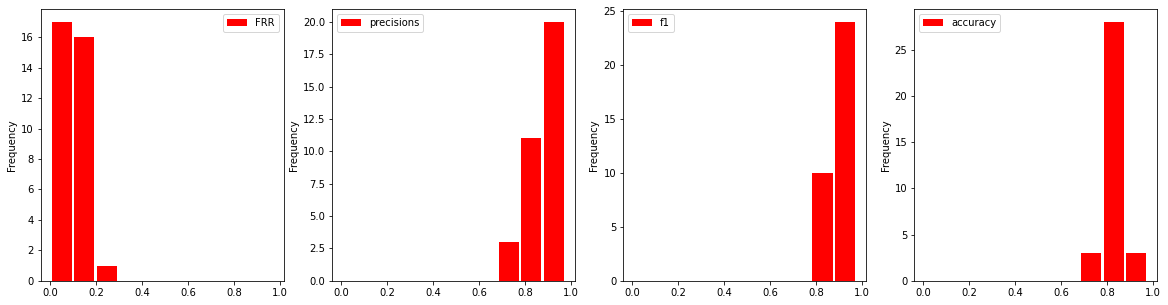

In [144]:
plt.rcParams.update({'font.size': 22}) # must set in top

# plot metrics histogram over subjects
data = np.array([FRRs, precisions, f1s, accuracys]).T
df_per_speaker = pd.DataFrame(data=data , columns=["FRR", "precisions", "f1", "accuracy"])
df_per_speaker.plot.hist(
    subplots=True, 
    legend=True, 
    layout=(1, 4),
    figsize=(20,4), 
    color="red", 
    rwidth=0.9, 
    color = (1,0.9, 0),
    fontsize=22);

## Conclusion & Discussions


I have developped a 1-layer GRU neural network detect speech activity with about 11% false rejection rate, on a low computing device


To improve the model the next steps would be to try a more thorough hyperparameter search:

- different learning rates
- more model architectures

To test the model in online speeck detection conditions with streaming audio data from a microphone:
- Add an streaming inference pipeline that makes online predictions

To deploy the model on constrained resource devices such as iOS or BlackBerry Pi:

- model quantization
- convert the model to tensorflow lite format for deployment on iOS


## References

## Supplementary results

## Each speaker first audio signal

SPEAKER 103 - PANEL 0
  data/01_raw/vad_data/103-1240-0001.wav
  data/01_raw/vad_data/103-1240-0001.json


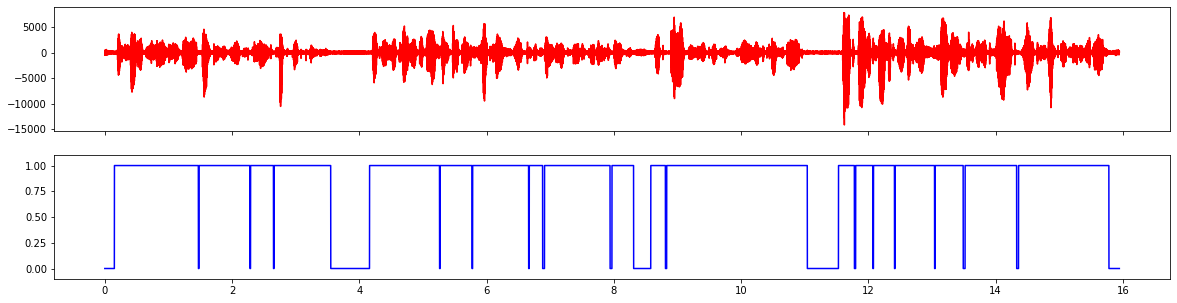

SPEAKER 1034 - PANEL 1
  data/01_raw/vad_data/1034-121119-0005.wav
  data/01_raw/vad_data/1034-121119-0005.json


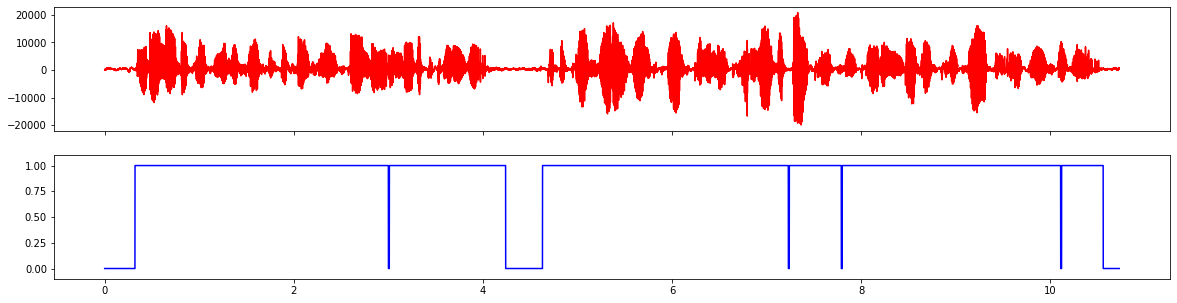

SPEAKER 1040 - PANEL 2
  data/01_raw/vad_data/1040-133433-0001.wav
  data/01_raw/vad_data/1040-133433-0001.json


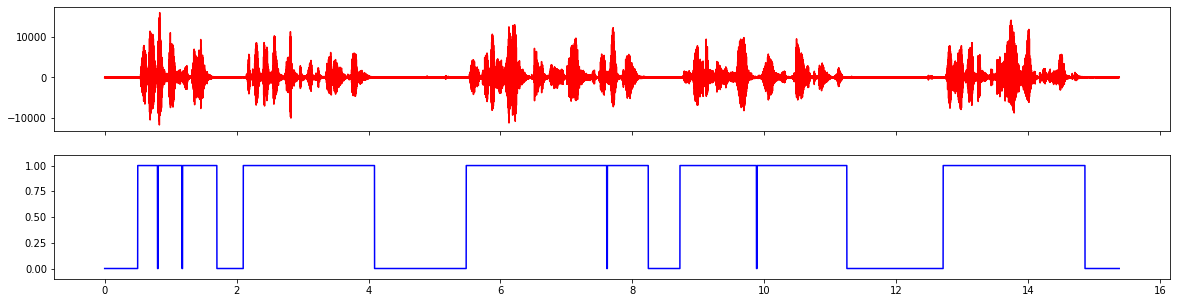

SPEAKER 1069 - PANEL 3
  data/01_raw/vad_data/1069-133699-0000.wav
  data/01_raw/vad_data/1069-133699-0000.json


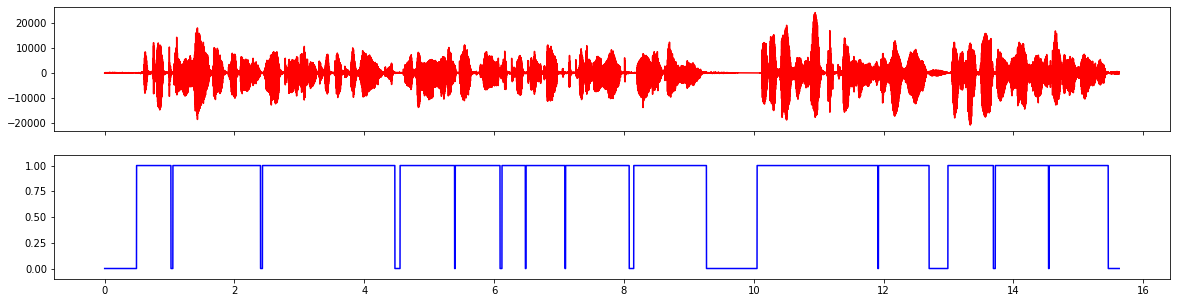

SPEAKER 1081 - PANEL 4
  data/01_raw/vad_data/1081-125237-0007.wav
  data/01_raw/vad_data/1081-125237-0007.json


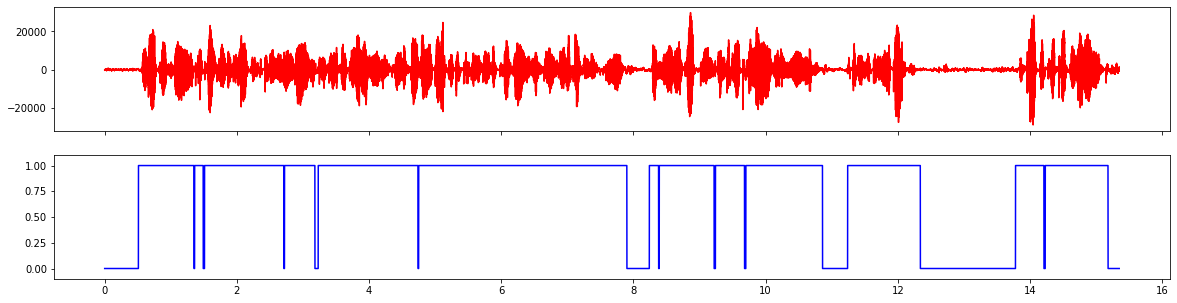

SPEAKER 1088 - PANEL 5
  data/01_raw/vad_data/1088-129236-0003.wav
  data/01_raw/vad_data/1088-129236-0003.json


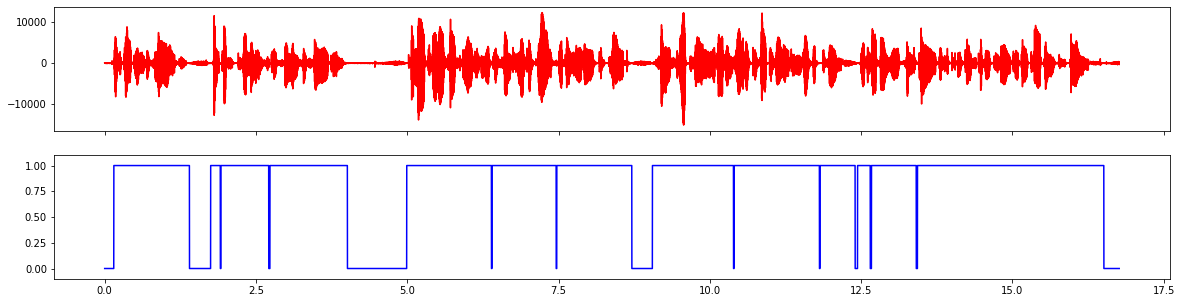

SPEAKER 1098 - PANEL 6
  data/01_raw/vad_data/1098-133695-0001.wav
  data/01_raw/vad_data/1098-133695-0001.json


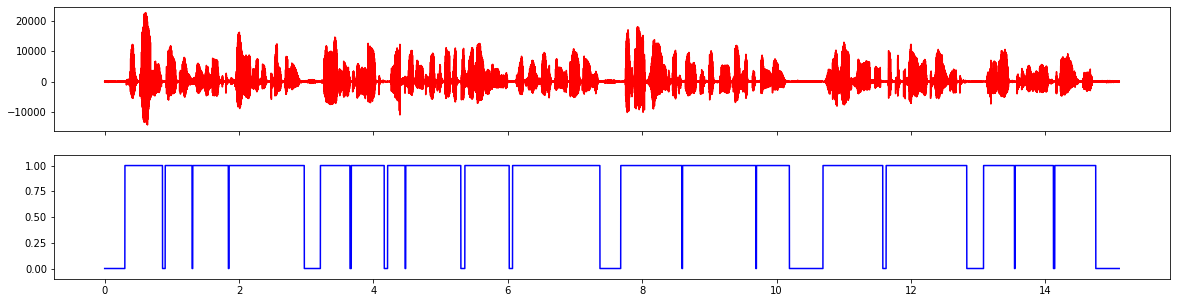

SPEAKER 1116 - PANEL 7
  data/01_raw/vad_data/1116-132847-0003.wav
  data/01_raw/vad_data/1116-132847-0003.json


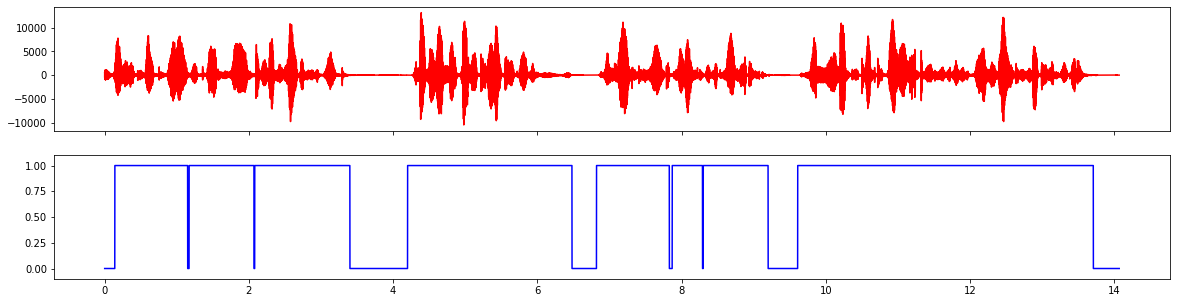

SPEAKER 118 - PANEL 8
  data/01_raw/vad_data/118-121721-0005.wav
  data/01_raw/vad_data/118-121721-0005.json


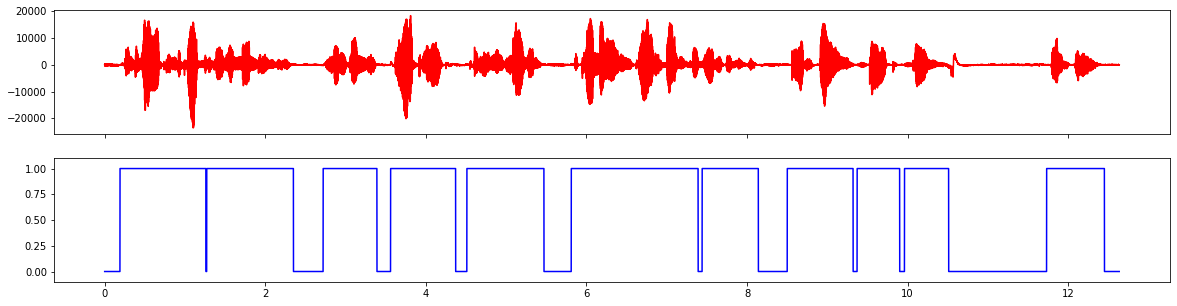

SPEAKER 1183 - PANEL 9
  data/01_raw/vad_data/1183-124566-0000.wav
  data/01_raw/vad_data/1183-124566-0000.json


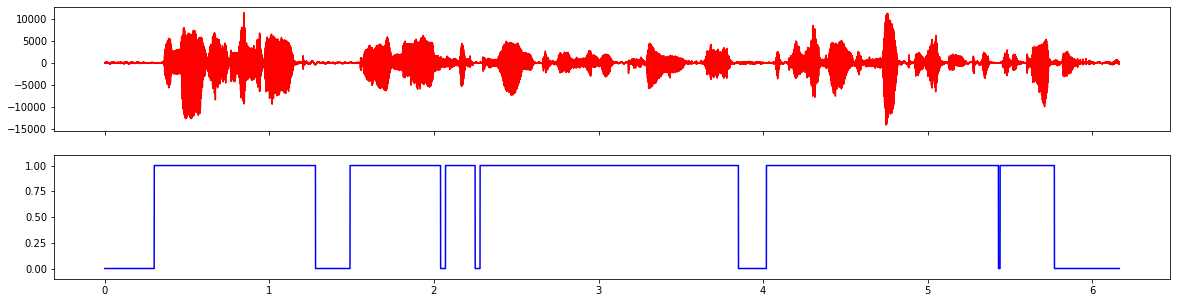

SPEAKER 1235 - PANEL 10
  data/01_raw/vad_data/1235-135883-0007.wav
  data/01_raw/vad_data/1235-135883-0007.json


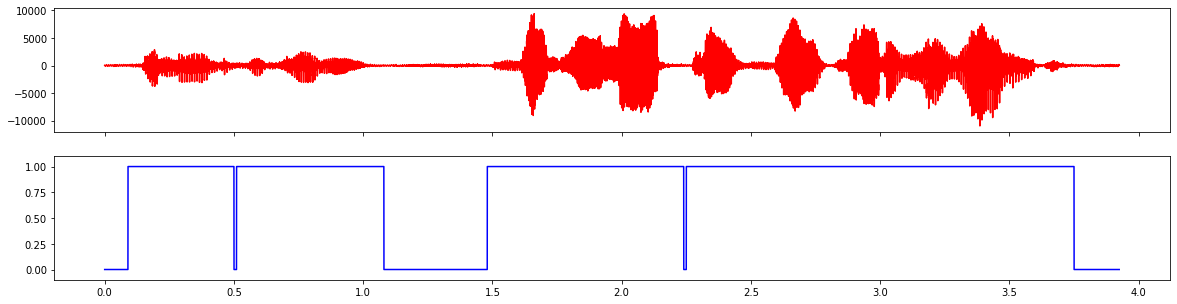

SPEAKER 1246 - PANEL 11
  data/01_raw/vad_data/1246-124548-0000.wav
  data/01_raw/vad_data/1246-124548-0000.json


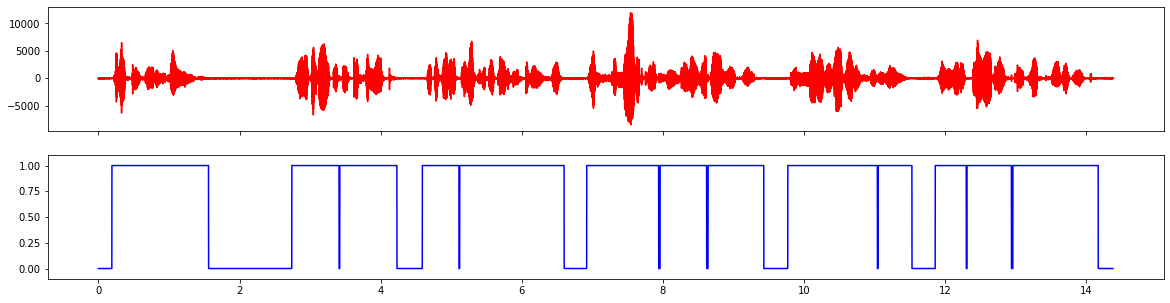

SPEAKER 125 - PANEL 12
  data/01_raw/vad_data/125-121124-0000.wav
  data/01_raw/vad_data/125-121124-0000.json


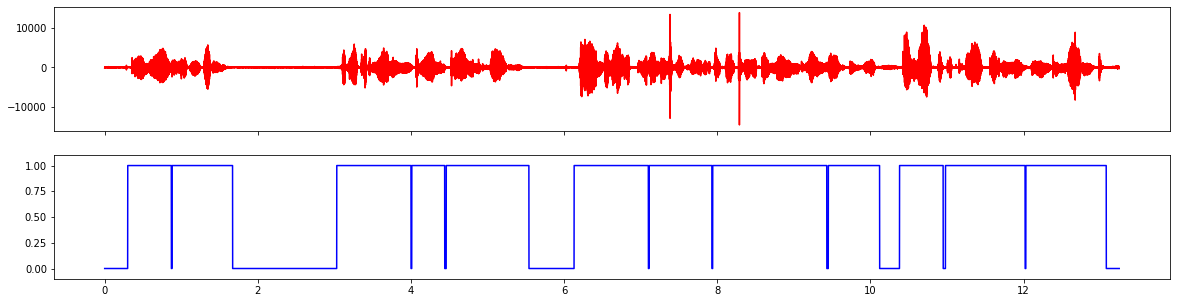

SPEAKER 1263 - PANEL 13
  data/01_raw/vad_data/1263-138246-0000.wav
  data/01_raw/vad_data/1263-138246-0000.json


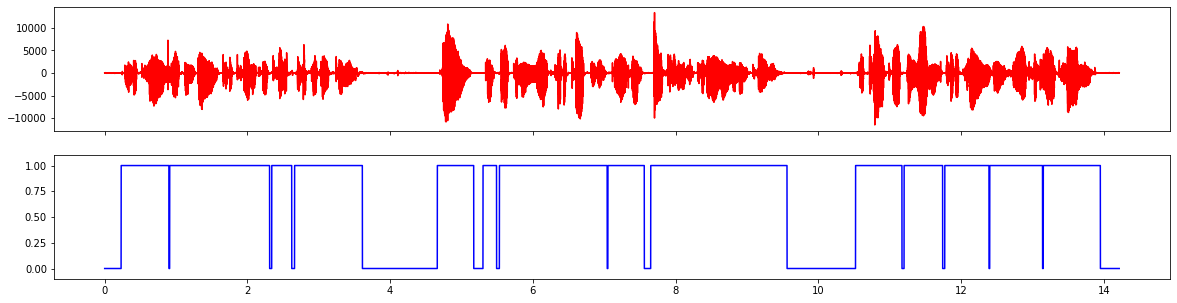

SPEAKER 1334 - PANEL 14
  data/01_raw/vad_data/1334-135589-0011.wav
  data/01_raw/vad_data/1334-135589-0011.json


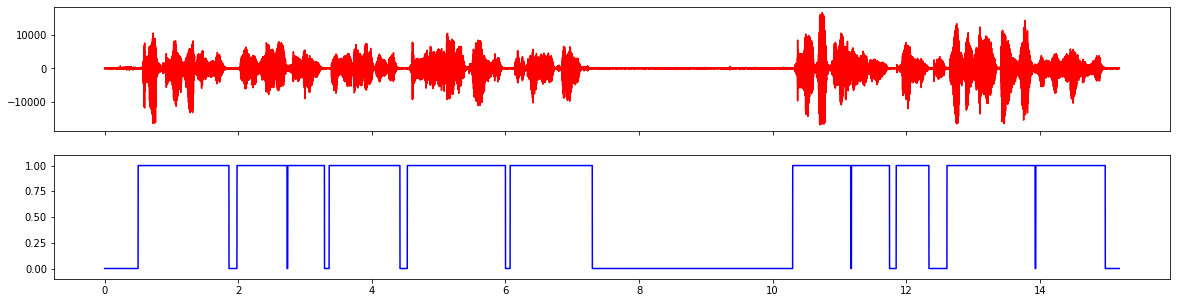

SPEAKER 1355 - PANEL 15
  data/01_raw/vad_data/1355-39947-0014.wav
  data/01_raw/vad_data/1355-39947-0014.json


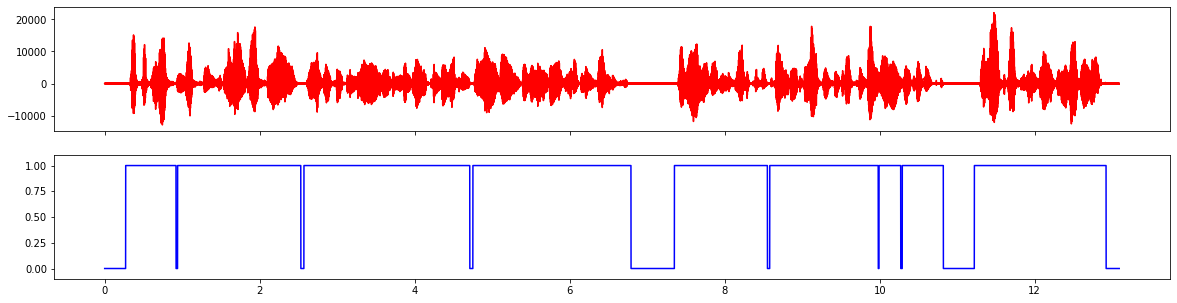

SPEAKER 1363 - PANEL 16
  data/01_raw/vad_data/1363-135842-0000.wav
  data/01_raw/vad_data/1363-135842-0000.json


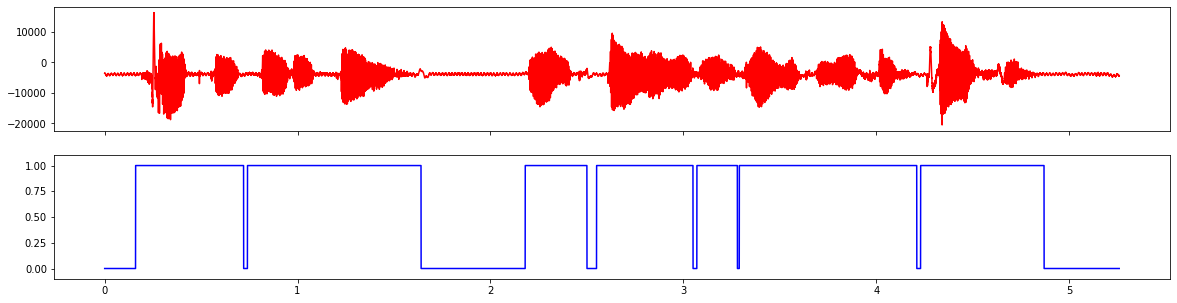

SPEAKER 1447 - PANEL 17
  data/01_raw/vad_data/1447-130550-0000.wav
  data/01_raw/vad_data/1447-130550-0000.json


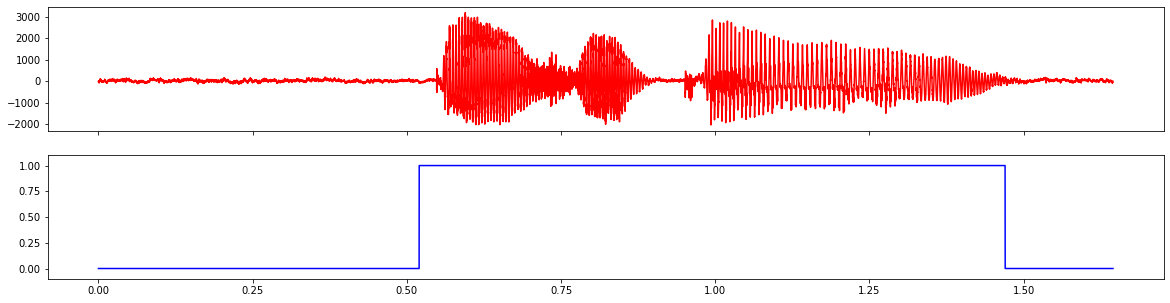

SPEAKER 1455 - PANEL 18
  data/01_raw/vad_data/1455-134435-0007.wav
  data/01_raw/vad_data/1455-134435-0007.json


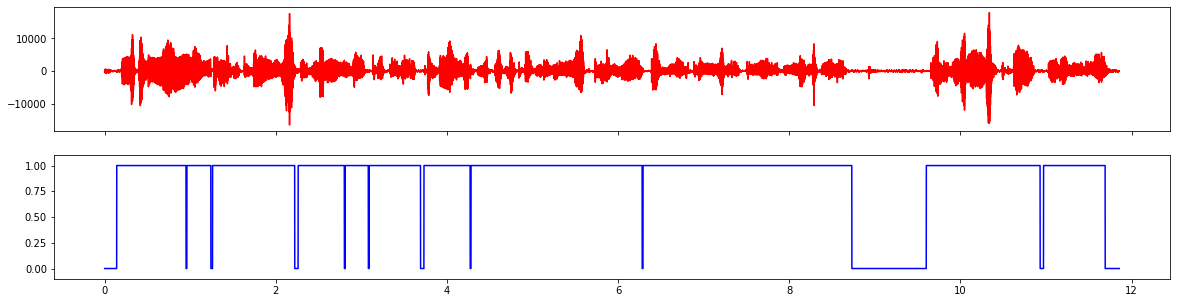

SPEAKER 150 - PANEL 19
  data/01_raw/vad_data/150-126107-0001.wav
  data/01_raw/vad_data/150-126107-0001.json


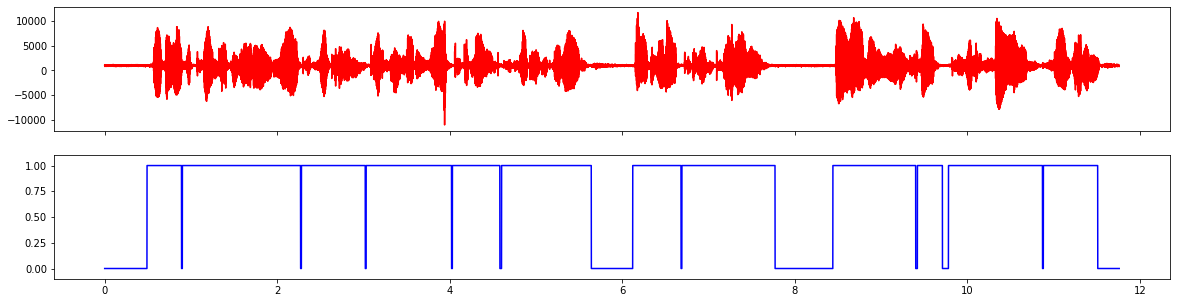

SPEAKER 1502 - PANEL 20
  data/01_raw/vad_data/1502-122615-0007.wav
  data/01_raw/vad_data/1502-122615-0007.json


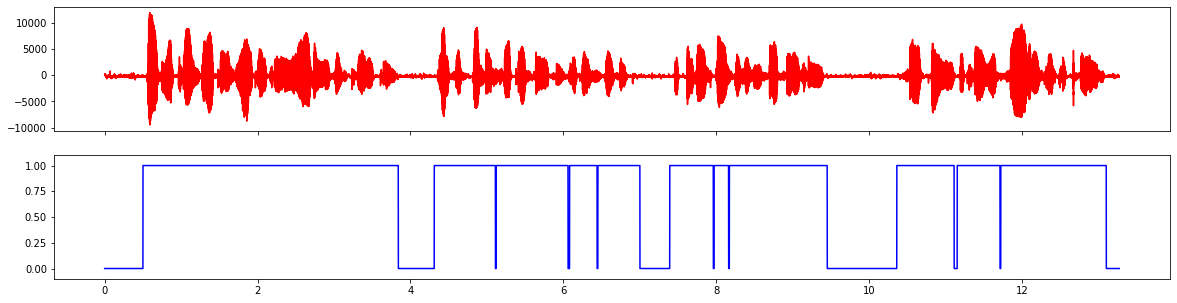

SPEAKER 1553 - PANEL 21
  data/01_raw/vad_data/1553-140047-0002.wav
  data/01_raw/vad_data/1553-140047-0002.json


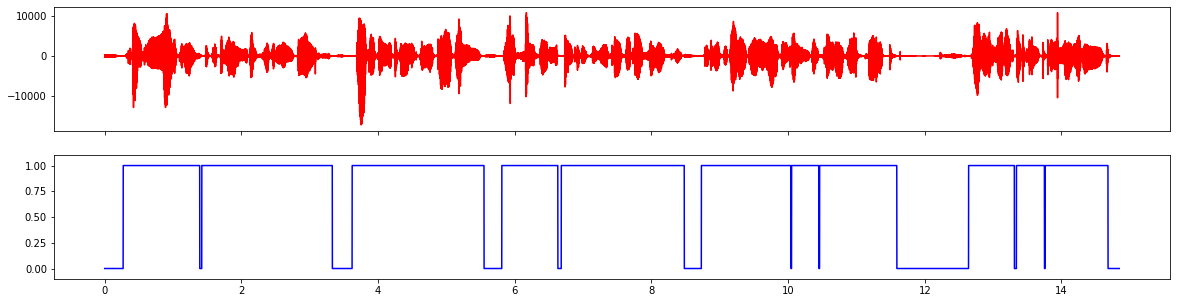

SPEAKER 1578 - PANEL 22
  data/01_raw/vad_data/1578-140045-0000.wav
  data/01_raw/vad_data/1578-140045-0000.json


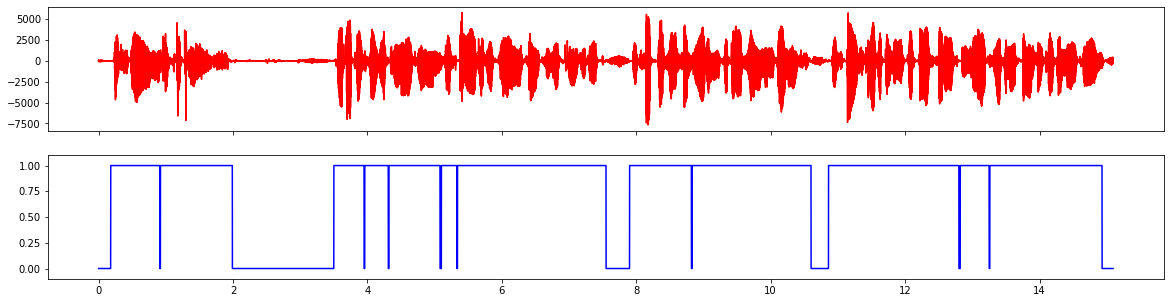

SPEAKER 1594 - PANEL 23
  data/01_raw/vad_data/1594-135914-0004.wav
  data/01_raw/vad_data/1594-135914-0004.json


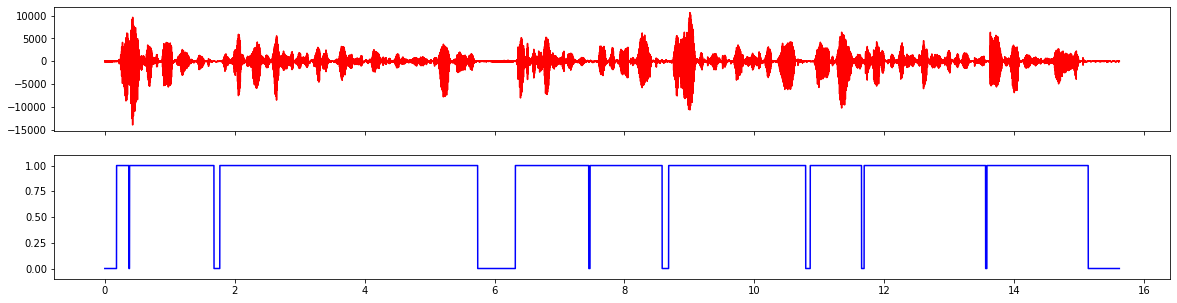

SPEAKER 1624 - PANEL 24
  data/01_raw/vad_data/1624-142933-0003.wav
  data/01_raw/vad_data/1624-142933-0003.json


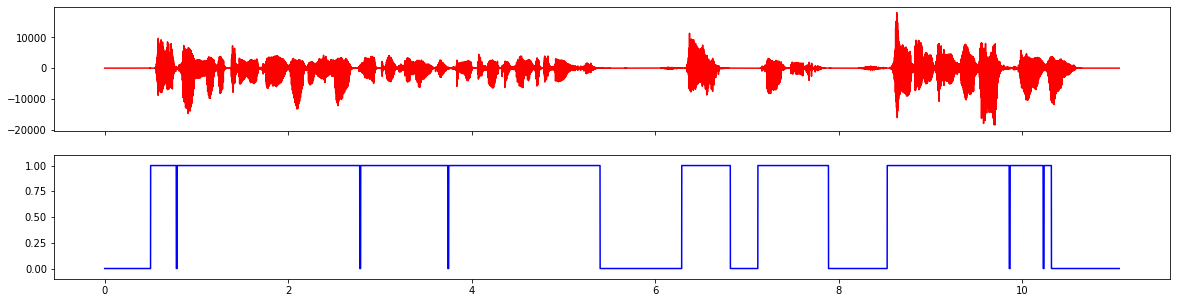

SPEAKER 163 - PANEL 25
  data/01_raw/vad_data/163-121908-0006.wav
  data/01_raw/vad_data/163-121908-0006.json


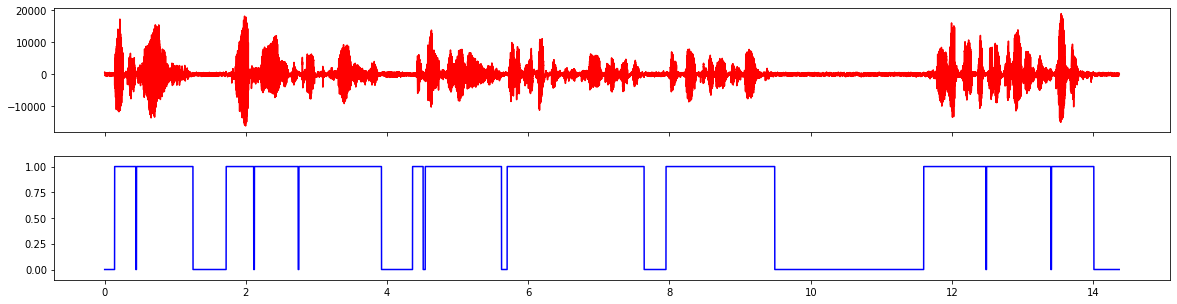

SPEAKER 1723 - PANEL 26
  data/01_raw/vad_data/1723-141149-0005.wav
  data/01_raw/vad_data/1723-141149-0005.json


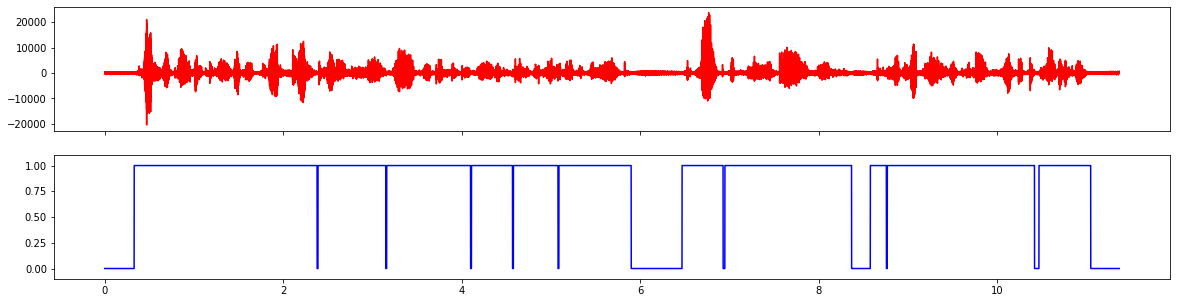

SPEAKER 1737 - PANEL 27
  data/01_raw/vad_data/1737-142396-0000.wav
  data/01_raw/vad_data/1737-142396-0000.json


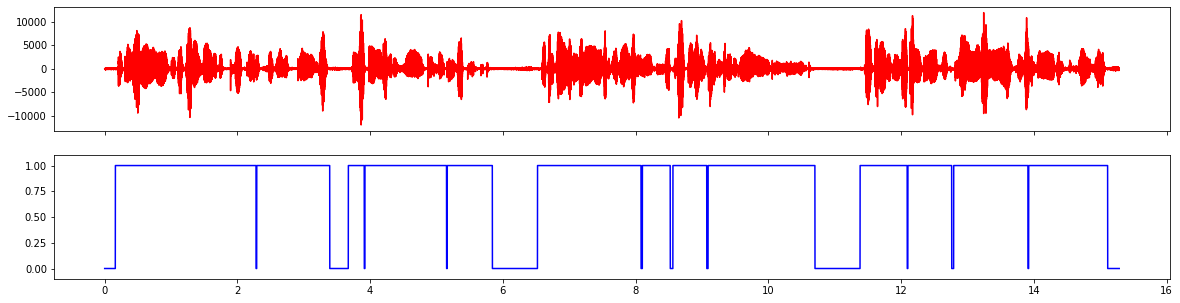

SPEAKER 1743 - PANEL 28
  data/01_raw/vad_data/1743-142912-0002.wav
  data/01_raw/vad_data/1743-142912-0002.json


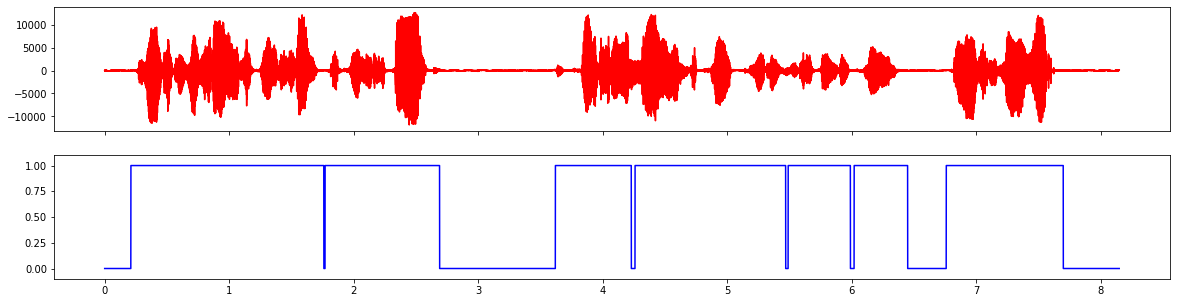

SPEAKER 1841 - PANEL 29
  data/01_raw/vad_data/1841-150351-0013.wav
  data/01_raw/vad_data/1841-150351-0013.json


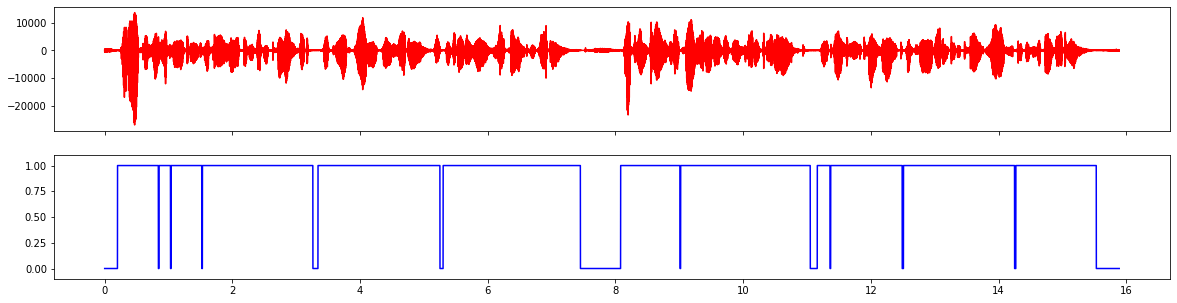

SPEAKER 1867 - PANEL 30
  data/01_raw/vad_data/1867-148436-0001.wav
  data/01_raw/vad_data/1867-148436-0001.json


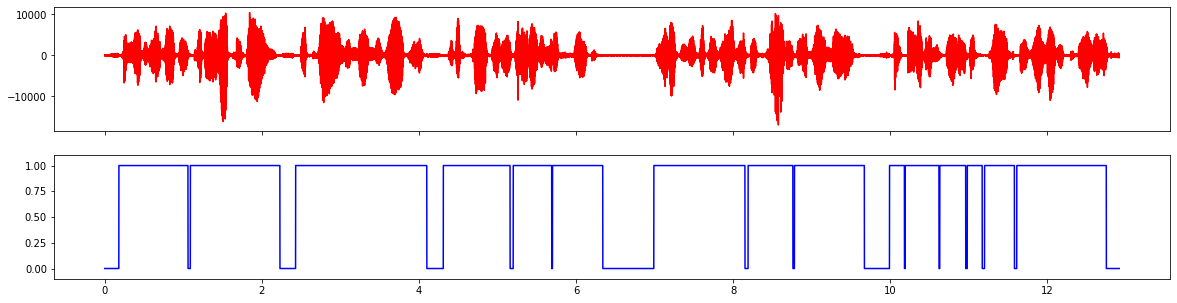

SPEAKER 1898 - PANEL 31
  data/01_raw/vad_data/1898-145702-0007.wav
  data/01_raw/vad_data/1898-145702-0007.json


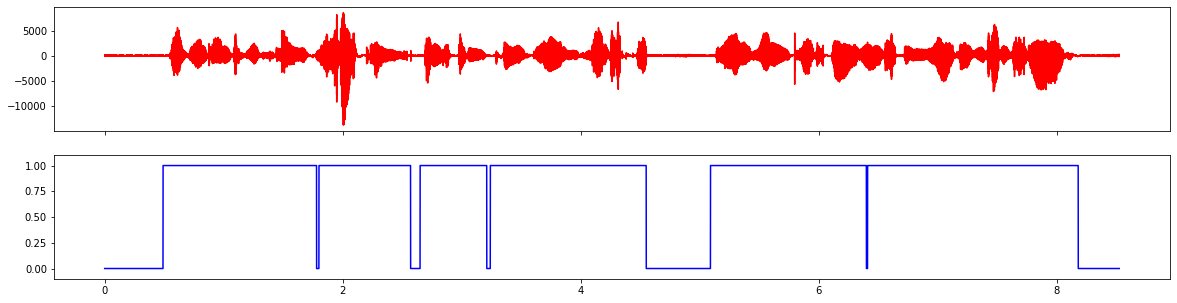

SPEAKER 19 - PANEL 32
  data/01_raw/vad_data/19-198-0003.wav
  data/01_raw/vad_data/19-198-0003.json


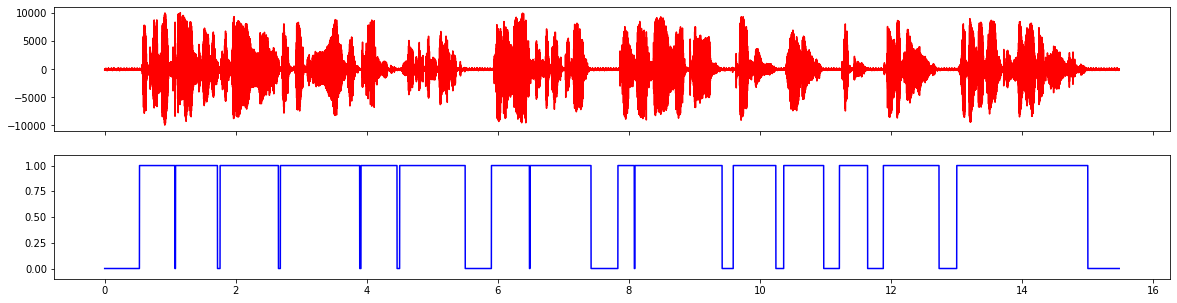

SPEAKER 1926 - PANEL 33
  data/01_raw/vad_data/1926-143879-0002.wav
  data/01_raw/vad_data/1926-143879-0002.json


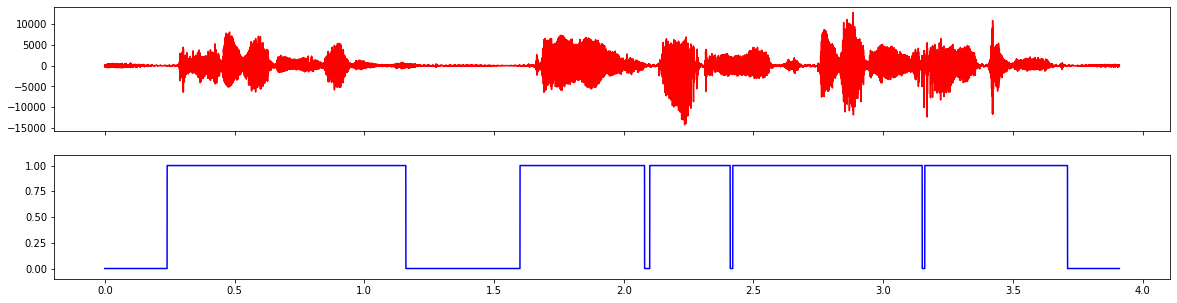

17.36 sec


In [145]:
# show an example per speaker
_, exple_pos = np.unique(file_speaker, return_index=True, axis=0)
    
# sync audio and labels
tic = time.time()
for ix, exple in enumerate(exple_pos):
    print(f"SPEAKER {file_speaker[exple]} - PANEL {ix}")
    print(" " ,audio_files[exple])
    print(" " ,label_files[exple])    
    audio = read_X(audio_files[exple])
    label = load_Y(label_files[exple])
    synced = sync_audio_and_labels(audio, label)
    f, ax1, ax2 = plot_labelled_audio(
        audio["audio"]["metadata"]["timestamp"], 
        audio["audio"]["data"], 
        audio["label"], 
        n_sample=len(audio["label"]), 
    )
if VERBOSE: 
    print(np.round(time.time()-tic,2), "sec")

## Experimental run tracking

Each run parameters was tracked with mlflow api.

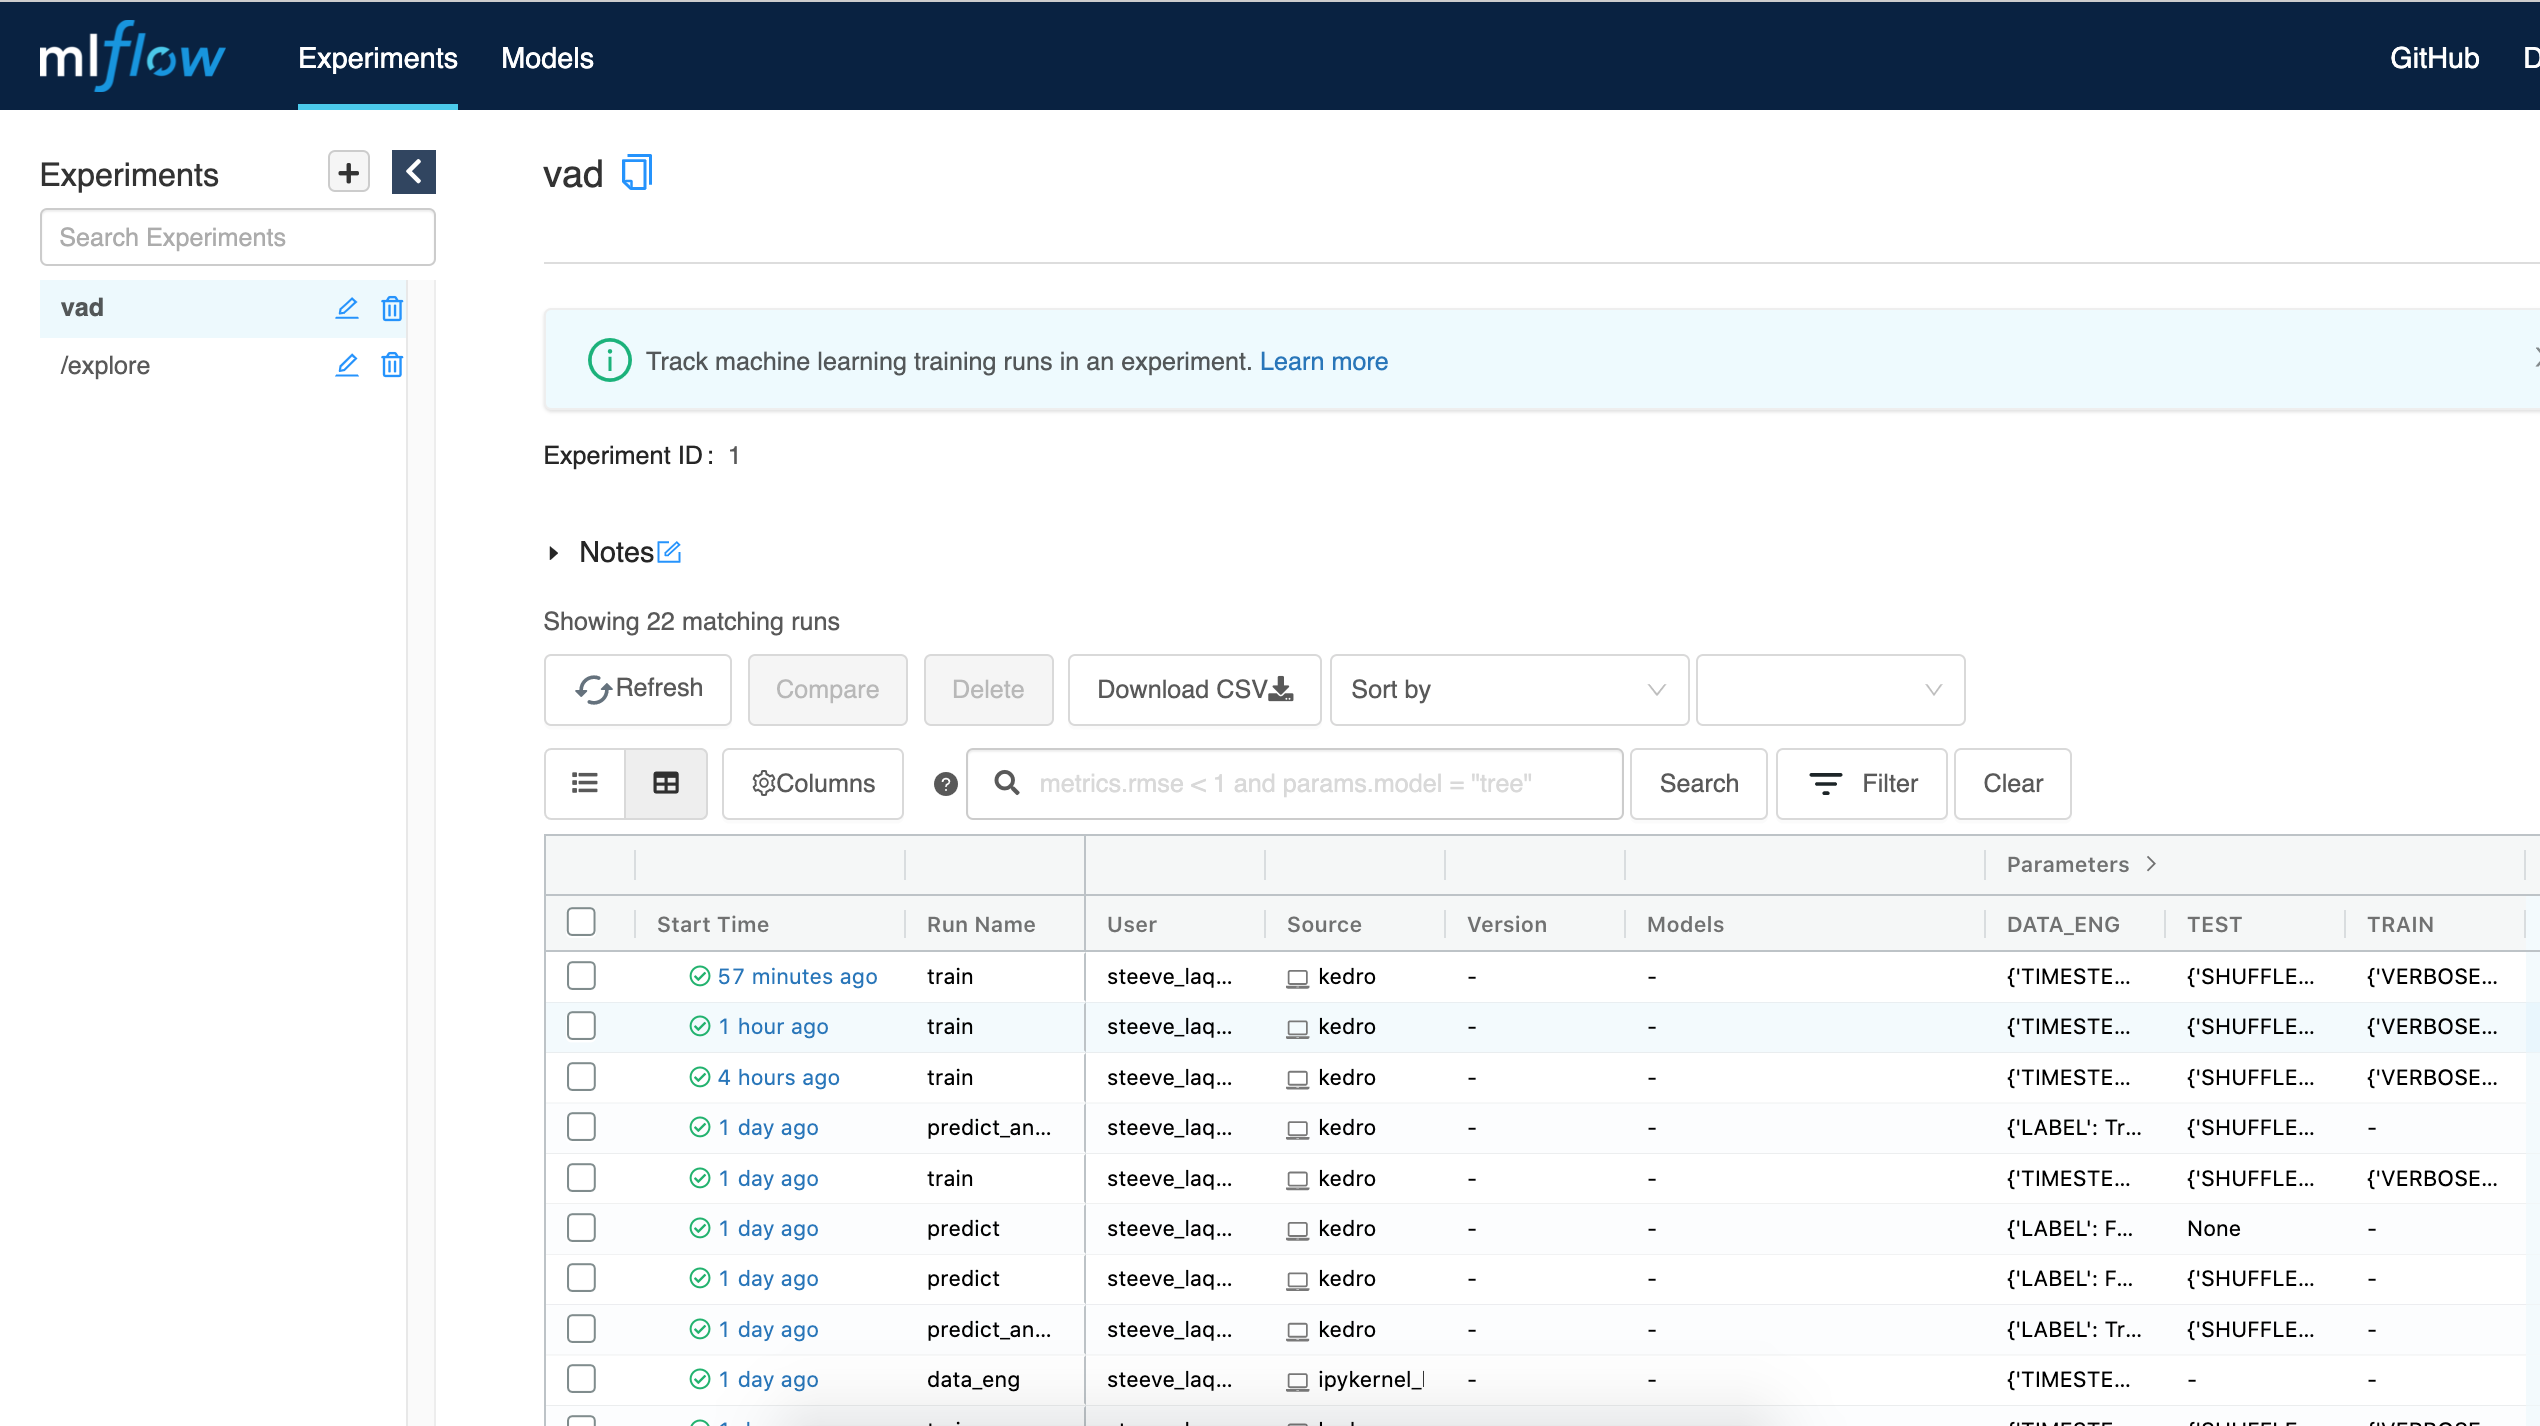

In [146]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/mlflow_tracking.png') 